In [ ]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 9.7 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
import cv2
from glob import glob
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import pandas as pd
import os
from tqdm import tqdm
from tensorflow.keras.utils import CustomObjectScope
from google.colab import files
import shutil
from tensorflow.keras.layers import *
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.metrics import f1_score, jaccard_score, precision_score, recall_score
import tensorflow.keras.layers as L
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import EfficientNetB0
#import visualkeras
import matplotlib.pyplot as plt
from PIL import ImageFont

In [ ]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [3]:
""" Global parameters """
H = 256
W = 256

import os
import shutil

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def load_dataset(path, split=0.2):
    images = sorted(glob(os.path.join(path, "images", "*.png")))
    masks = sorted(glob(os.path.join(path, "masks", "*.png")))

    min_length = min(len(images), len(masks))
    images = images[:min_length]
    masks = masks[:min_length]

    split_size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (h, w)
    x = cv2.resize(x, (W, H))   ## (h, w)
    x = x / 255.0               ## (h, w)
    x = x.astype(np.float32)    ## (h, w)
    x = np.expand_dims(x, axis=-1)## (h, w, 1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset

""" Seeding """
np.random.seed(42)
tf.random.set_seed(42)

""" Directory for storing files """
create_dir("files")

""" Hyperparameters """
batch_size = 16
lr = 1e-4
num_epochs = 50
model_path = os.path.join("files", "model.h5")
csv_path = os.path.join("files", "log.csv")

""" Dataset """
dataset_path = "/content/drive/MyDrive/Colab Notebooks/BrainMRI/data"
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")
print(f"Test : {len(test_x)} - {len(test_y)}")

train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)


Train: 1377 - 1377
Valid: 459 - 459
Test : 459 - 459


In [4]:
def save_results(image, mask, y_pred, save_image_path):
    mask = np.expand_dims(mask, axis=-1)
    mask = np.concatenate([mask, mask, mask], axis=-1)

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)
    y_pred = y_pred * 255

    line = np.ones((H, 10, 3)) * 255

    cat_images = np.concatenate([image, line, mask, line, y_pred], axis=1)
    cv2.imwrite(save_image_path, cat_images)

""" Directory for storing files """
create_dir("results")

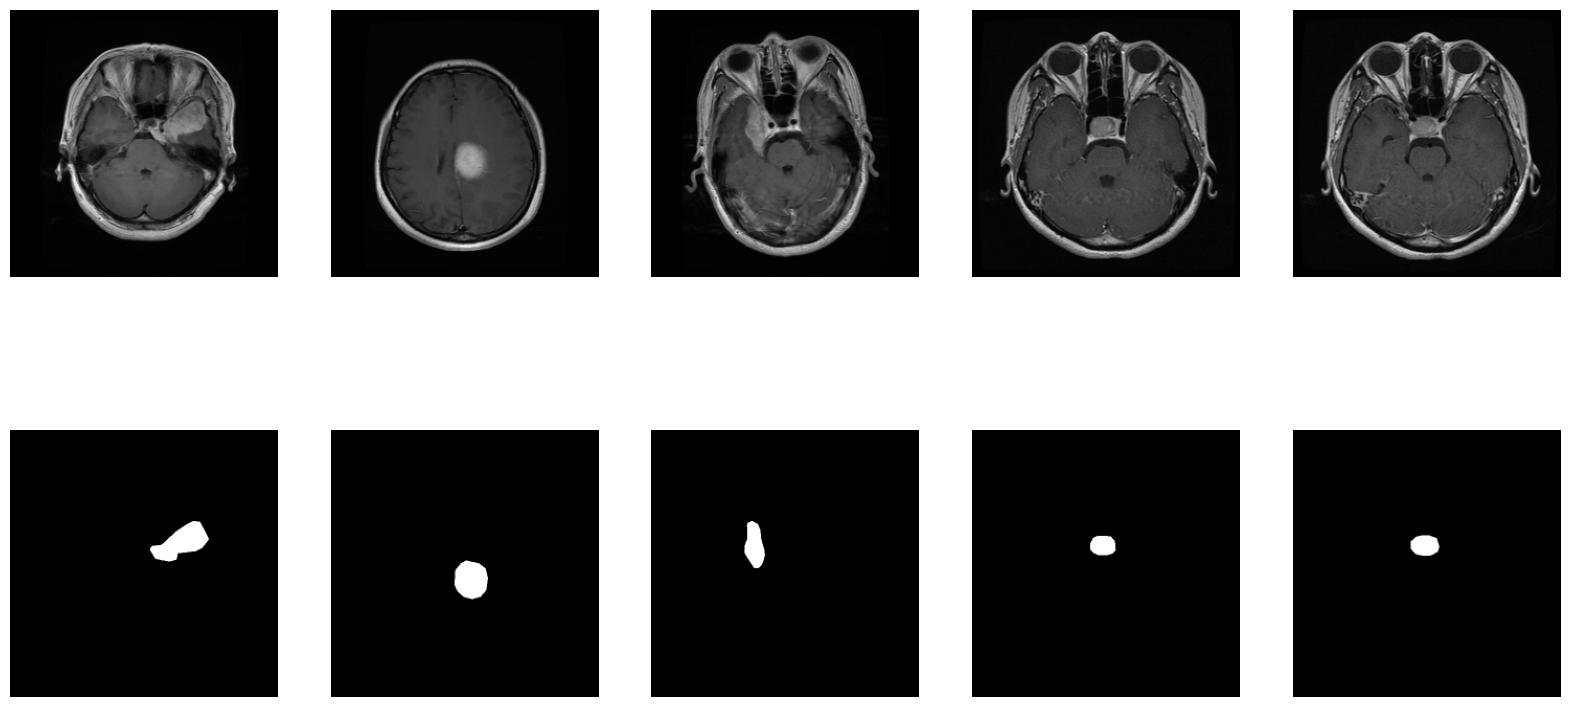

In [8]:
def read_mask1(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x
def display_examples(image_paths, mask_paths, num_examples=5):
    plt.figure(figsize=(20, 10))
    for i in range(num_examples):
        image = cv2.imread(image_paths[i], cv2.IMREAD_COLOR)
        image = cv2.resize(image, (W, H))
        image = image / 255.0
        image = image.astype(np.float32)

        mask = read_mask1(mask_paths[i])

        plt.subplot(2, num_examples, i+1)
        plt.imshow(image)
        plt.axis('off')

        plt.subplot(2, num_examples, num_examples + i+1)
        plt.imshow(mask[:, :, 0], cmap='gray')
        plt.axis('off')

    plt.show()

images = sorted(glob(os.path.join(dataset_path, "images", "*.png")))
masks = sorted(glob(os.path.join(dataset_path, "masks", "*.png")))

display_examples(images, masks)

# U_net

In [ ]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNET")
    return model

input_shape = (256, 256, 3)
model = build_unet(input_shape)
model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 256, 256, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_18 (Ba  (None, 256, 256, 64)         256       ['conv2d_19[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_18 (Activation)  (None, 256, 256, 64)         0         ['batch_normalization_18[0]

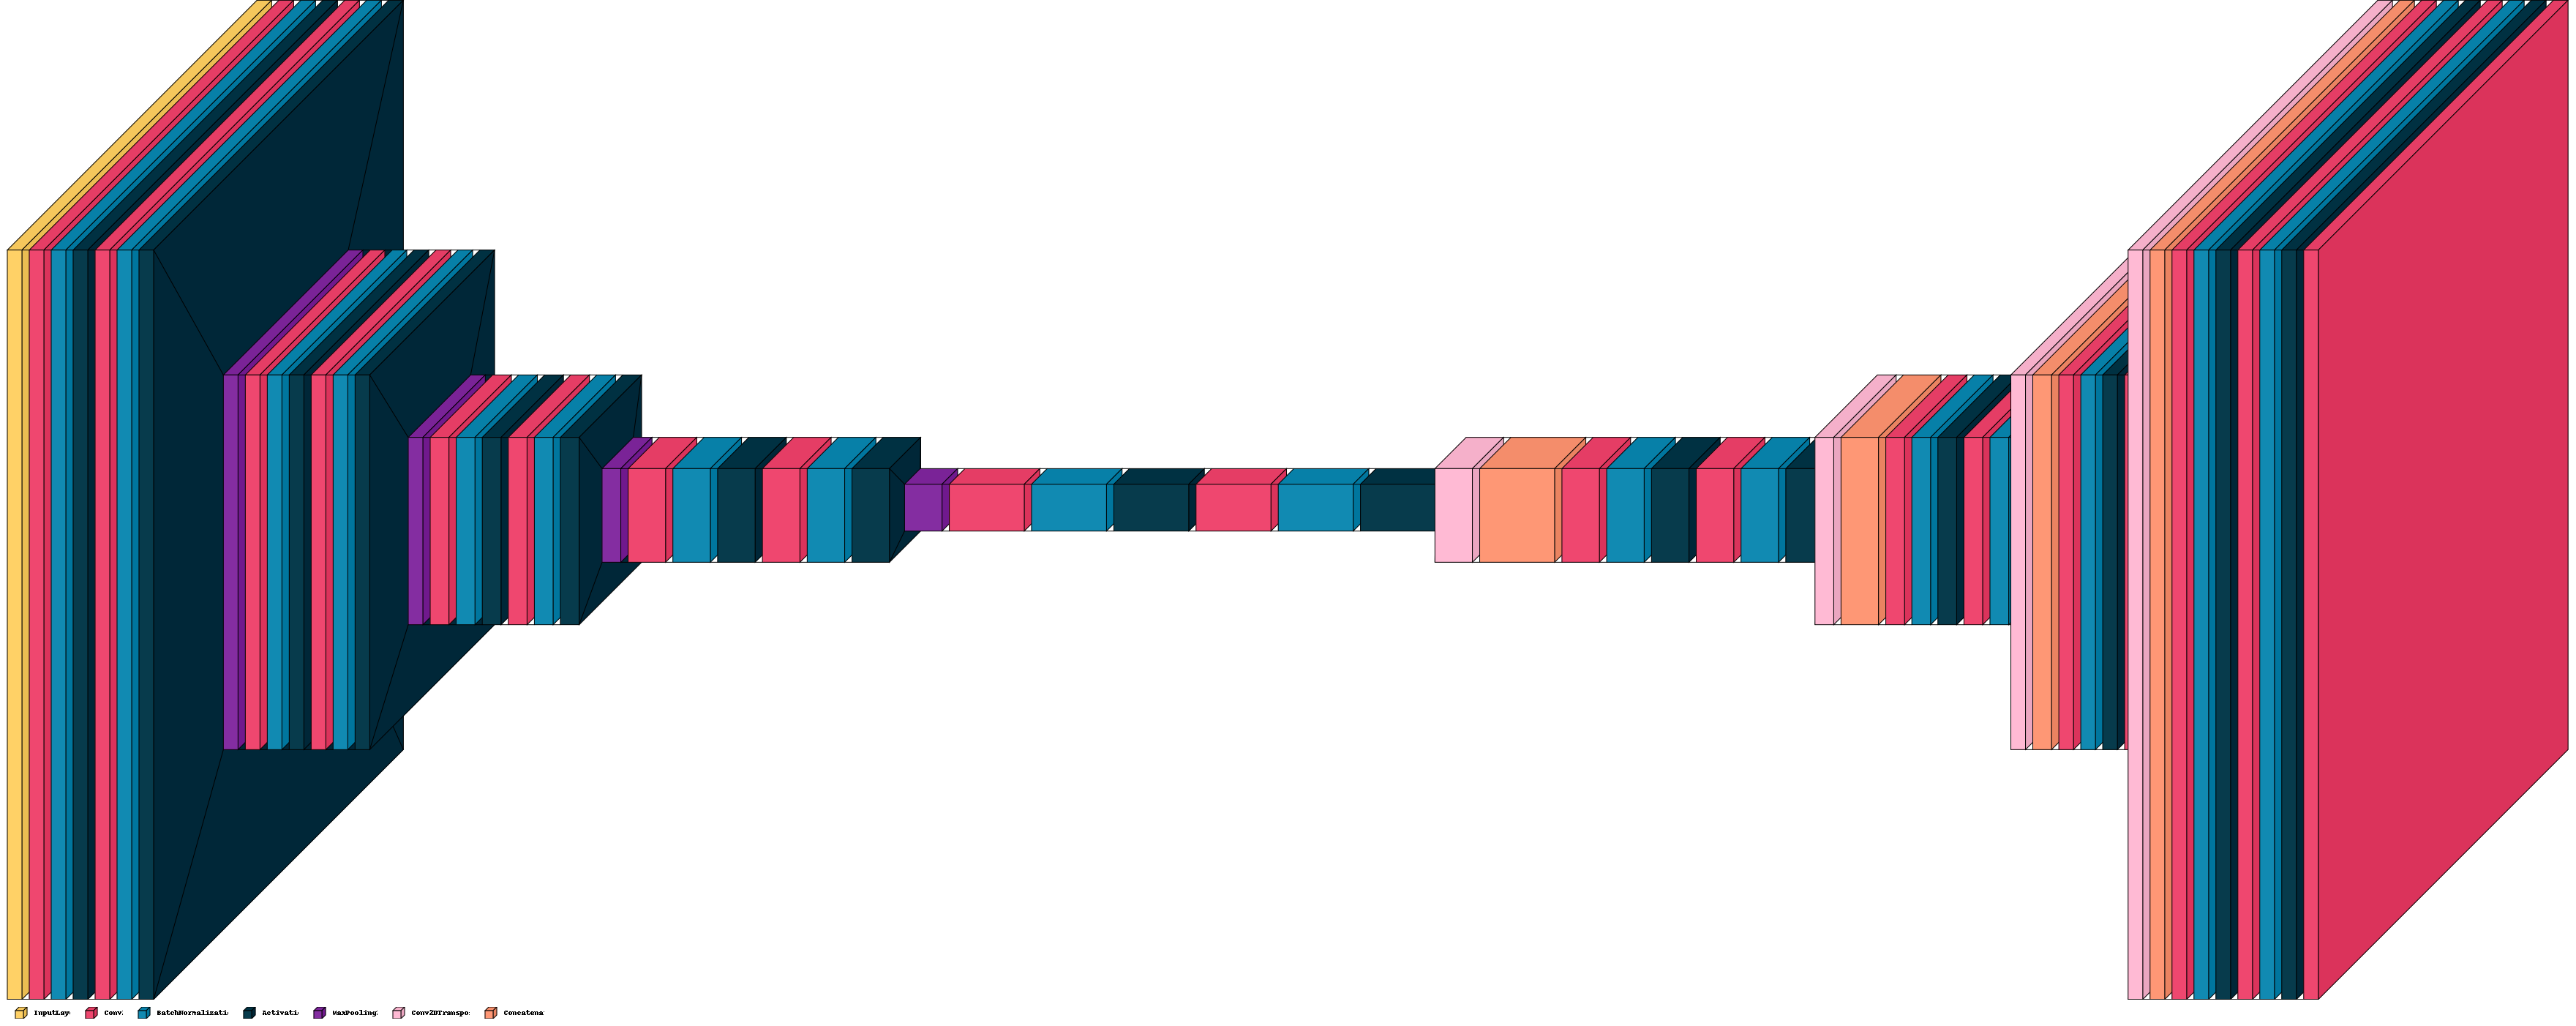

In [ ]:
visualkeras.layered_view(model, legend=True)
#visualkeras.layered_view(model, legend=True)

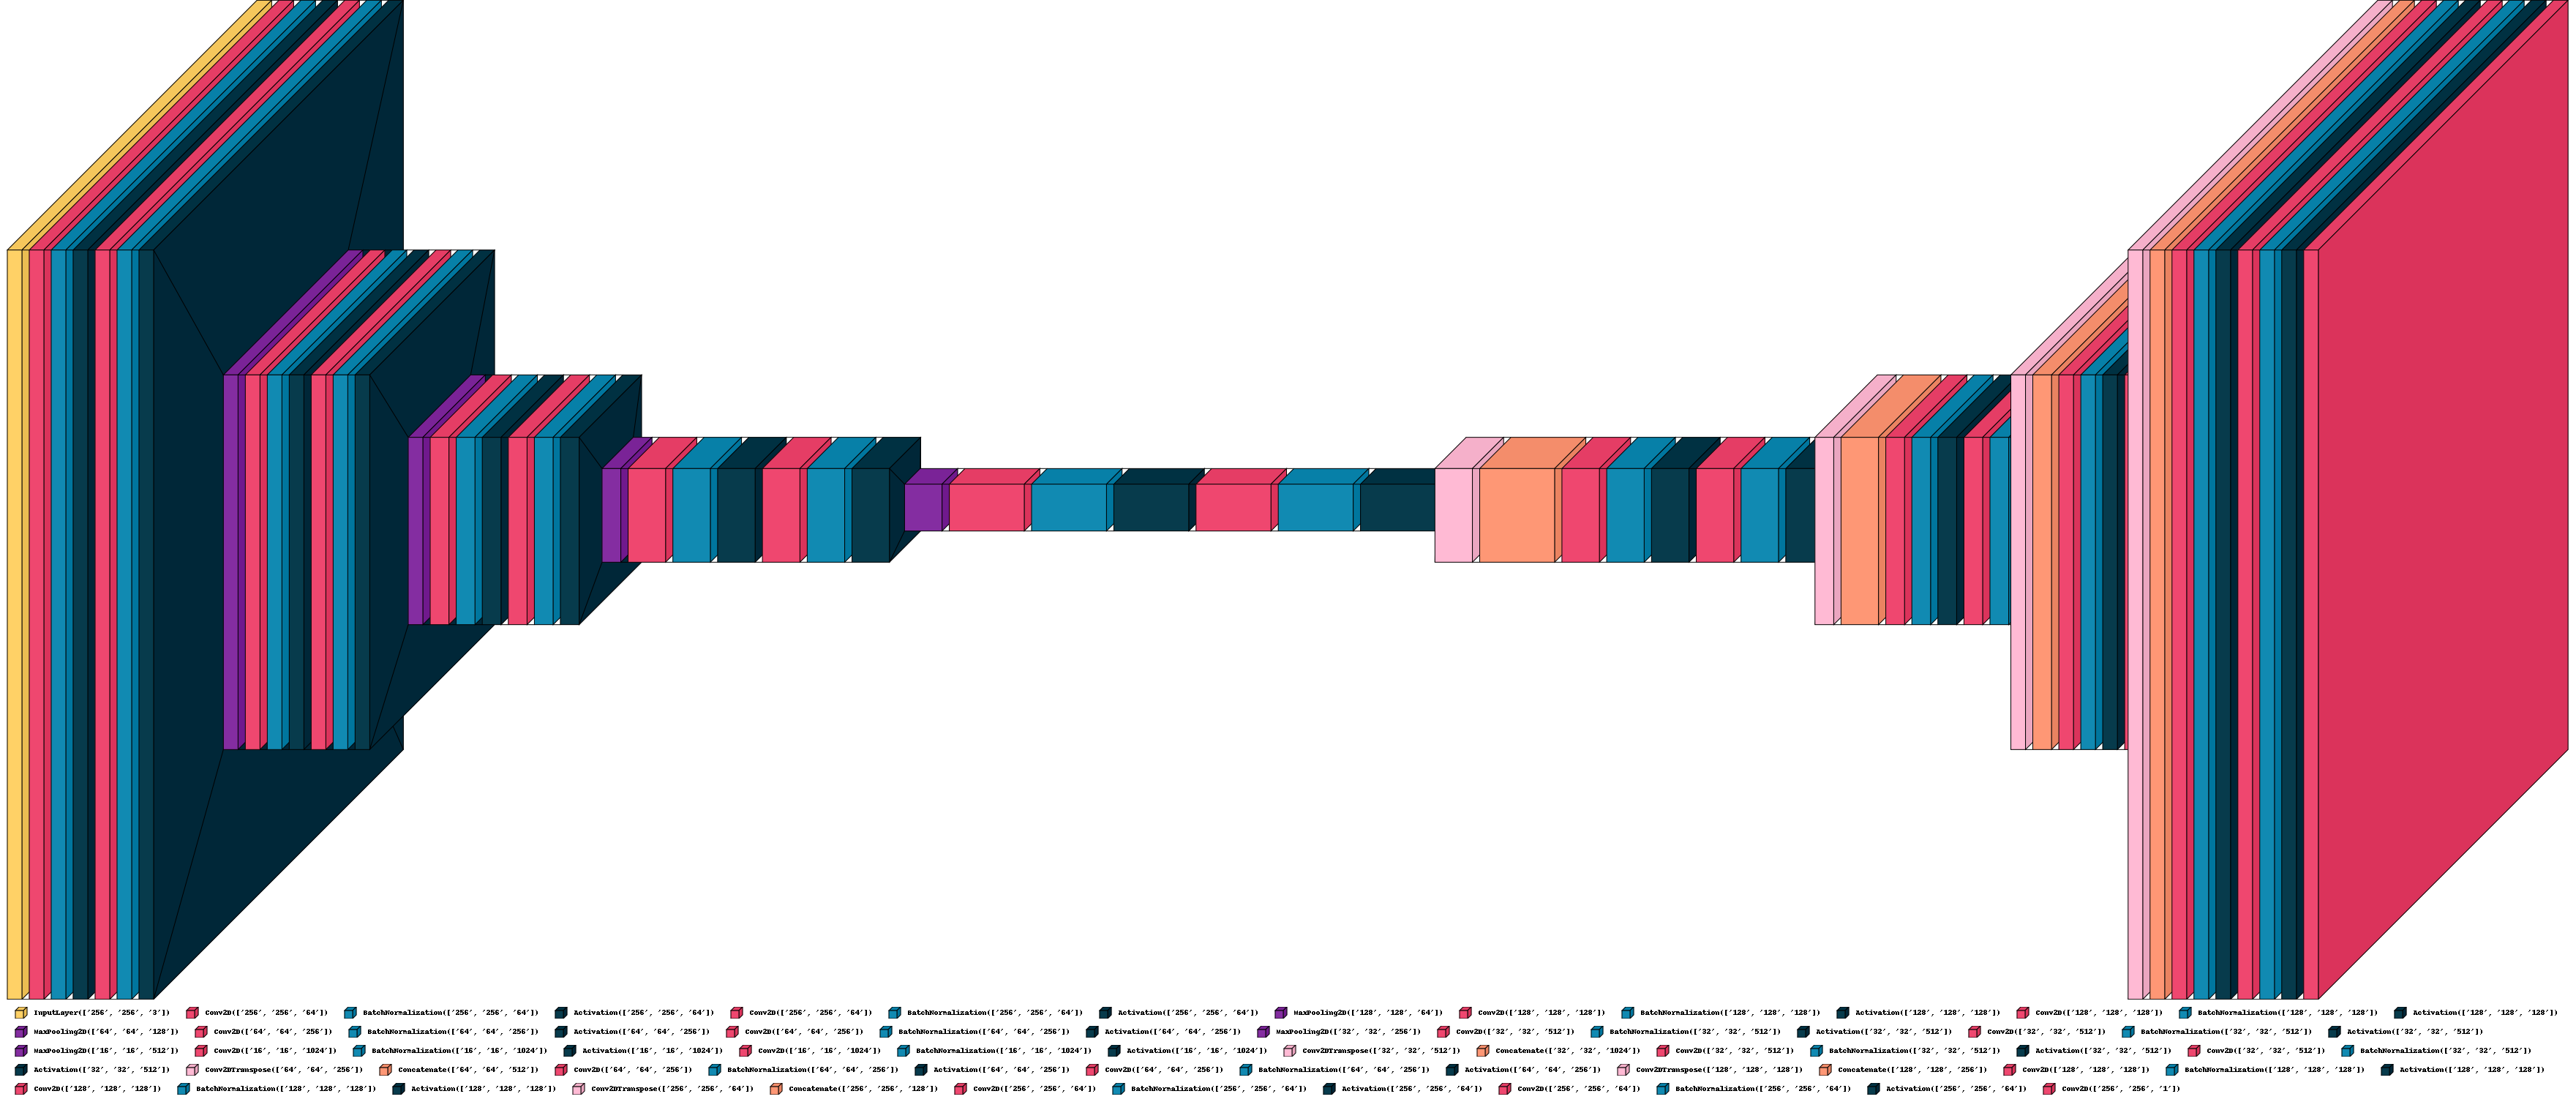

In [ ]:
visualkeras.layered_view(model, legend=True, show_dimension=True)

In [ ]:
""" Model """
model = build_unet((H, W, 3))
model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coef])

callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    CSVLogger(csv_path),
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
    ]

model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    callbacks=callbacks
)

Train: 1377 - 1377
Valid: 459 - 459
Test : 459 - 459
Epoch 1/50
44/44 [==============================] - ETA: 0s - loss: 0.9164 - dice_coef: 0.0844
Epoch 1: val_loss improved from inf to 0.96956, saving model to files/model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


44/44 [==============================] - 707s 15s/step - loss: 0.9164 - dice_coef: 0.0844 - val_loss: 0.9696 - val_dice_coef: 0.0300 - lr: 1.0000e-04
Epoch 2/50
43/44 [============================>.] - ETA: 0s - loss: 0.8229 - dice_coef: 0.1771
Epoch 2: val_loss did not improve from 0.96956
44/44 [==============================] - 46s 1s/step - loss: 0.8229 - dice_coef: 0.1772 - val_loss: 0.9742 - val_dice_coef: 0.0255 - lr: 1.0000e-04
Epoch 3/50
43/44 [============================>.] - ETA: 0s - loss: 0.7637 - dice_coef: 0.2363
Epoch 3: val_loss did not improve from 0.96956
44/44 [==============================] - 47s 1s/step - loss: 0.7638 - dice_coef: 0.2359 - val_loss: 0.9817 - val_dice_coef: 0.0182 - lr: 1.0000e-04
Epoch 4/50
43/44 [============================>.] - ETA: 0s - loss: 0.7302 - dice_coef: 0.2698
Epoch 4: val_loss did not improve from 0.96956
44/44 [==============================] - 47s 1s/step - loss: 0.7301 - dice_coef: 0.2708 - val_loss: 0.9811 - val_dice_coef: 0.01

In [ ]:
""" Load the model """
with CustomObjectScope({"dice_coef": dice_coef, "dice_loss": dice_loss}):
    model = tf.keras.models.load_model(os.path.join("files", "model.h5"))
""" Prediction and Evaluation """
SCORE = []
for x, y in tqdm(zip(test_x, test_y), total=len(test_y)):
    """ Extracting the name """
    name = x.split("/")[-1]

    """ Reading the image """
    image = cv2.imread(x, cv2.IMREAD_COLOR) ## [H, w, 3]
    image = cv2.resize(image, (W, H))       ## [H, w, 3]
    x = image/255.0                         ## [H, w, 3]
    x = np.expand_dims(x, axis=0)           ## [1, H, w, 3]

    """ Reading the mask """
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (W, H))

    """ Prediction """
    y_pred = model.predict(x, verbose=0)[0]
    y_pred = np.squeeze(y_pred, axis=-1)
    y_pred = y_pred >= 0.5
    y_pred = y_pred.astype(np.int32)

    """ Saving the prediction """
    save_image_path = os.path.join("results", name)
    save_results(image, mask, y_pred, save_image_path)

    """ Flatten the array """
    mask = mask/255.0
    mask = (mask > 0.5).astype(np.int32).flatten()
    y_pred = y_pred.flatten()

    """ Calculating the metrics values """
    f1_value = f1_score(mask, y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(mask, y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
    precision_value = precision_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
    SCORE.append([name, f1_value, jac_value, recall_value, precision_value])

""" Metrics values """
score = [s[1:] for s in SCORE]
score = np.mean(score, axis=0)
print(f"F1: {score[0]:0.5f}")
print(f"Jaccard: {score[1]:0.5f}")
print(f"Recall: {score[2]:0.5f}")
print(f"Precision: {score[3]:0.5f}")

df = pd.DataFrame(SCORE, columns=["Image", "F1", "Jaccard", "Recall", "Precision"])
df.to_csv("files/score.csv")

# Zip the results folder
shutil.make_archive('results', 'zip', 'results')

# Download the zip file
files.download('results.zip')


100%|██████████| 459/459 [01:53<00:00,  4.03it/s]


F1: 0.66565
Jaccard: 0.56768
Recall: 0.71053
Precision: 0.69687


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Unet cai tien
- Attention Mechanism: Thêm Attention Gate trong các decoder_block để tăng cường thông tin từ các tầng trước đó.
- GroupNormalization và Dropout: Vẫn giữ GroupNormalization và Dropout để cải thiện khả năng tổng quát của mô hình và giảm overfitting.


In [ ]:
def conv_block(inputs, num_filters, dropout_rate=0.3):
    x = L.Conv2D(num_filters, 3, padding="same")(inputs)
    x = L.GroupNormalization(groups=8)(x)
    x = L.Activation("relu")(x)
    x = L.Dropout(dropout_rate)(x)

    x = L.Conv2D(num_filters, 3, padding="same")(x)
    x = L.GroupNormalization(groups=8)(x)
    x = L.Activation("relu")(x)
    x = L.Dropout(dropout_rate)(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = L.MaxPool2D((2, 2))(x)
    return x, p

def attention_gate(g, s, num_filters):
    Wg = L.Conv2D(num_filters, 1, padding="same")(g)
    Wg = L.BatchNormalization()(Wg)

    Ws = L.Conv2D(num_filters, 1, padding="same")(s)
    Ws = L.BatchNormalization()(Ws)

    out = L.Activation("relu")(Wg + Ws)
    out = L.Conv2D(num_filters, 1, padding="same")(out)
    out = L.Activation("sigmoid")(out)

    return out * s

def decoder_block(inputs, skip_features, num_filters):
    x = L.Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    skip_features = attention_gate(x, skip_features, num_filters)
    x = L.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_attention_unet(input_shape):
    inputs = L.Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = L.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="Attention-UNET")
    return model

input_shape = (256, 256, 3)
model_unet_improve = build_attention_unet(input_shape)
model_unet_improve.summary()


Model: "Attention-UNET"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 256, 256, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 group_normalization (Group  (None, 256, 256, 64)         128       ['conv2d_19[0][0]']           
 Normalization)                                                                                   
                                                                                                  
 activation_18 (Activation)  (None, 256, 256, 64)         0         ['group_normaliza

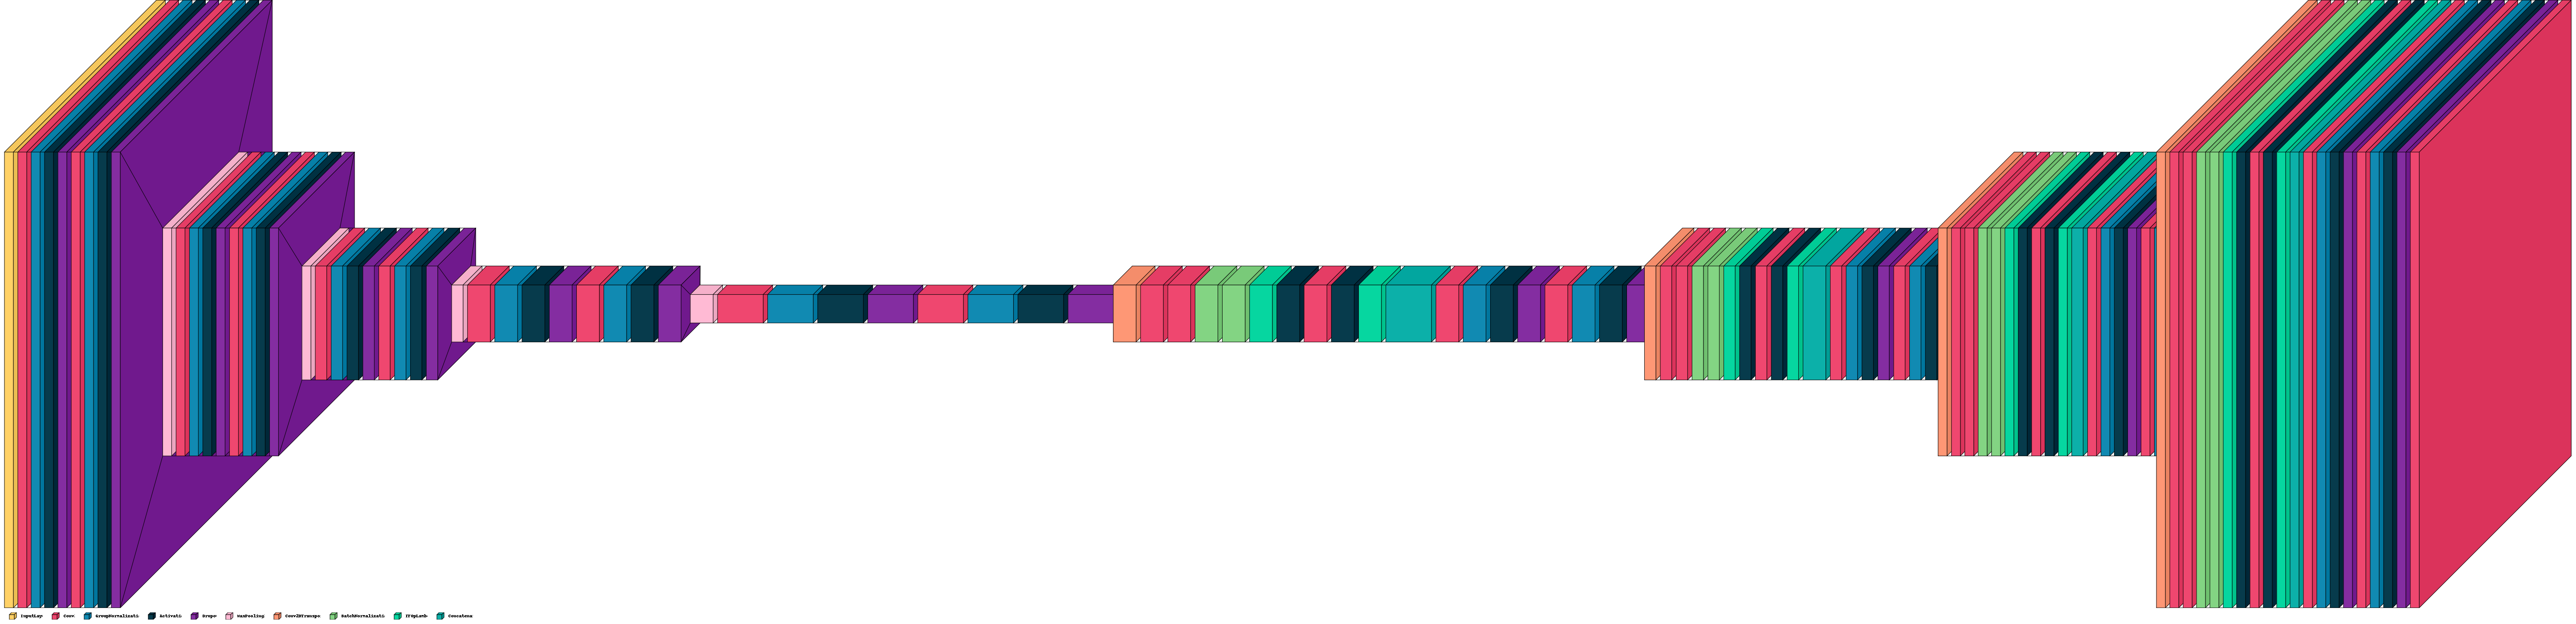

In [ ]:
visualkeras.layered_view(model_unet_improve, legend=True)

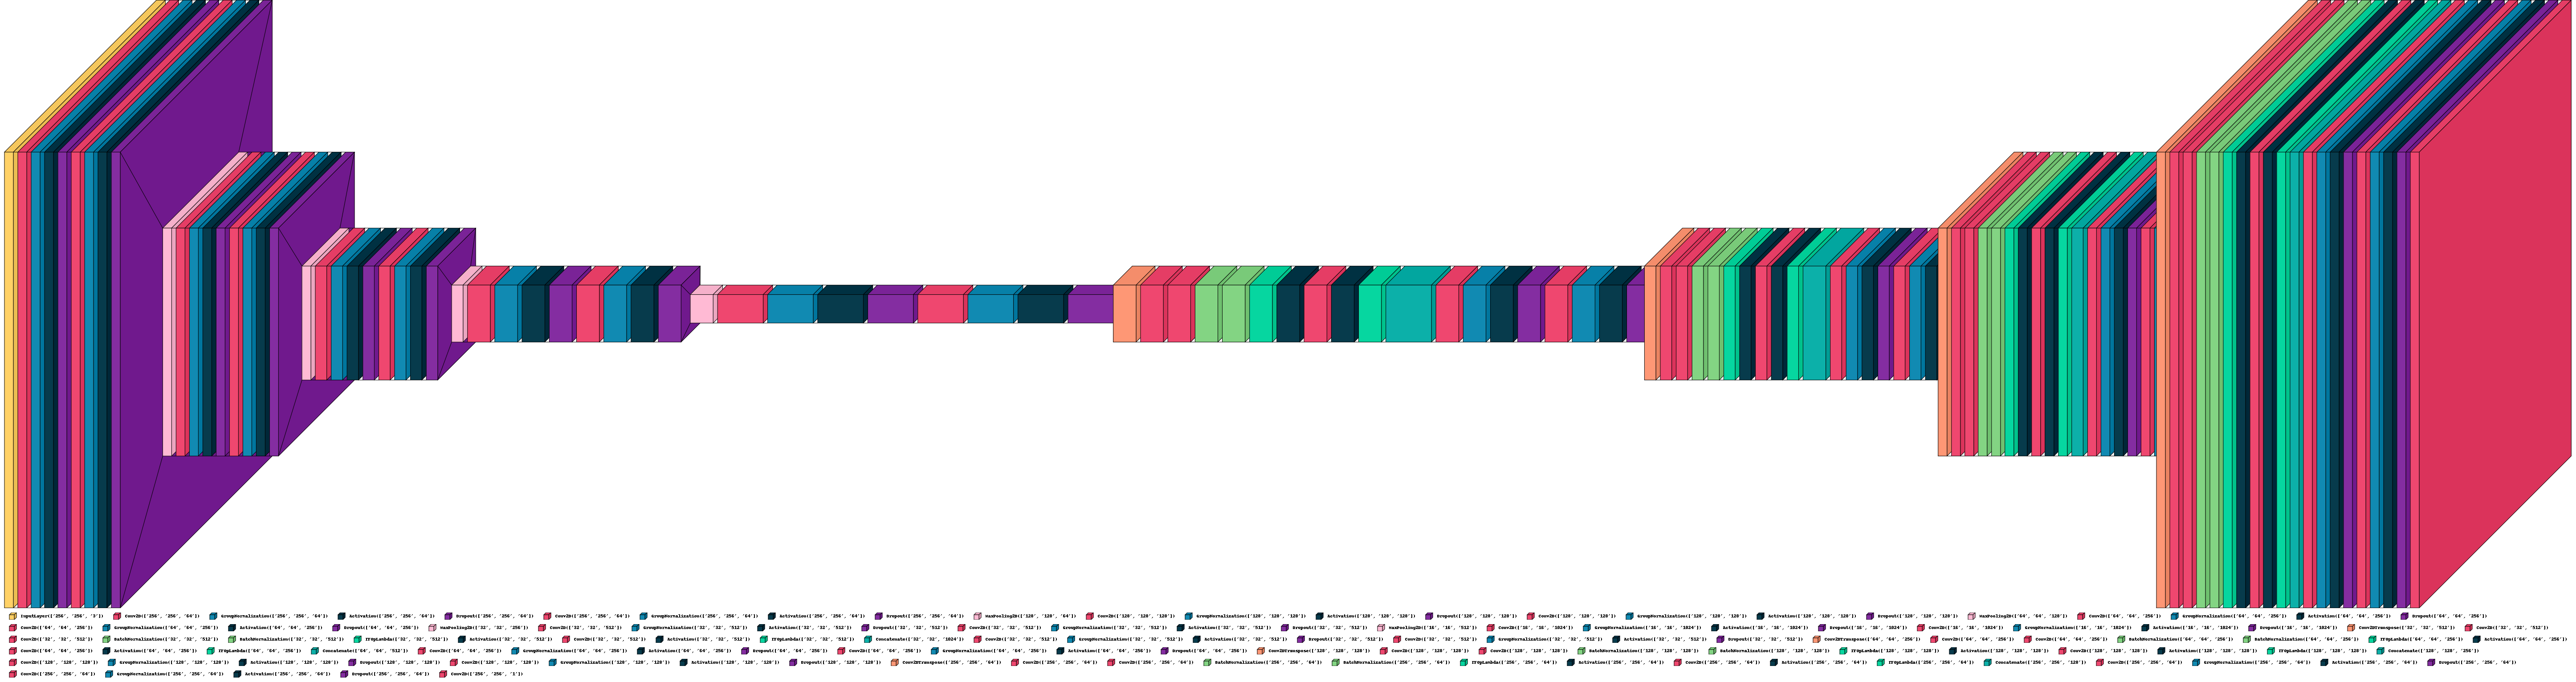

In [ ]:
visualkeras.layered_view(model_unet_improve, legend=True, show_dimension=True)

In [ ]:
""" Model """
model = build_attention_unet((H, W, 3))
model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coef])

callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    CSVLogger(csv_path),
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
    ]

model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    callbacks=callbacks
)

Train: 1377 - 1377
Valid: 459 - 459
Test : 459 - 459
Epoch 1/50
87/87 [==============================] - ETA: 0s - loss: 0.8732 - dice_coef: 0.1281 
Epoch 1: val_loss improved from inf to 0.76715, saving model to files/model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


87/87 [==============================] - 1657s 18s/step - loss: 0.8732 - dice_coef: 0.1281 - val_loss: 0.7672 - val_dice_coef: 0.2326 - lr: 1.0000e-04
Epoch 2/50
87/87 [==============================] - ETA: 0s - loss: 0.7509 - dice_coef: 0.2530
Epoch 2: val_loss improved from 0.76715 to 0.75774, saving model to files/model.h5
87/87 [==============================] - 115s 1s/step - loss: 0.7509 - dice_coef: 0.2530 - val_loss: 0.7577 - val_dice_coef: 0.2427 - lr: 1.0000e-04
Epoch 3/50
87/87 [==============================] - ETA: 0s - loss: 0.6724 - dice_coef: 0.3327
Epoch 3: val_loss improved from 0.75774 to 0.71848, saving model to files/model.h5
87/87 [==============================] - 116s 1s/step - loss: 0.6724 - dice_coef: 0.3327 - val_loss: 0.7185 - val_dice_coef: 0.2817 - lr: 1.0000e-04
Epoch 4/50
87/87 [==============================] - ETA: 0s - loss: 0.6117 - dice_coef: 0.3909
Epoch 4: val_loss improved from 0.71848 to 0.68851, saving model to files/model.h5
87/87 [==========

In [ ]:
""" Load the model """
with CustomObjectScope({"dice_coef": dice_coef, "dice_loss": dice_loss}):
    model = tf.keras.models.load_model(os.path.join("files", "model.h5"))


""" Prediction and Evaluation """
SCORE = []
for x, y in tqdm(zip(test_x, test_y), total=len(test_y)):
    """ Extracting the name """
    name = x.split("/")[-1]

    """ Reading the image """
    image = cv2.imread(x, cv2.IMREAD_COLOR) ## [H, w, 3]
    image = cv2.resize(image, (W, H))       ## [H, w, 3]
    x = image/255.0                         ## [H, w, 3]
    x = np.expand_dims(x, axis=0)           ## [1, H, w, 3]

    """ Reading the mask """
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (W, H))

    """ Prediction """
    y_pred = model.predict(x, verbose=0)[0]
    y_pred = np.squeeze(y_pred, axis=-1)
    y_pred = y_pred >= 0.5
    y_pred = y_pred.astype(np.int32)

    """ Saving the prediction """
    save_image_path = os.path.join("results", name)
    save_results(image, mask, y_pred, save_image_path)

    """ Flatten the array """
    mask = mask/255.0
    mask = (mask > 0.5).astype(np.int32).flatten()
    y_pred = y_pred.flatten()

    """ Calculating the metrics values """
    f1_value = f1_score(mask, y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(mask, y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
    precision_value = precision_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
    SCORE.append([name, f1_value, jac_value, recall_value, precision_value])

""" Metrics values """
score = [s[1:] for s in SCORE]
score = np.mean(score, axis=0)
print(f"F1: {score[0]:0.5f}")
print(f"Jaccard: {score[1]:0.5f}")
print(f"Recall: {score[2]:0.5f}")
print(f"Precision: {score[3]:0.5f}")

df = pd.DataFrame(SCORE, columns=["Image", "F1", "Jaccard", "Recall", "Precision"])
df.to_csv("files/score.csv")

# Zip the results folder
shutil.make_archive('results', 'zip', 'results')

# Download the zip file
files.download('results.zip')


100%|██████████| 459/459 [08:27<00:00,  1.11s/it]


F1: 0.70407
Jaccard: 0.60719
Recall: 0.74504
Precision: 0.71021


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# resUnet.py

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate, Input
from tensorflow.keras.models import Model

def batchnorm_relu(inputs):
    """ Batch Normalization & ReLU """
    x = BatchNormalization()(inputs)
    x = Activation("relu")(x)
    return x

def residual_block(inputs, num_filters, strides=1):
    """ Convolutional Layers """
    x = batchnorm_relu(inputs)
    x = Conv2D(num_filters, 3, padding="same", strides=strides)(x)
    x = batchnorm_relu(x)
    x = Conv2D(num_filters, 3, padding="same", strides=1)(x)

    """ Shortcut Connection (Identity Mapping) """
    s = Conv2D(num_filters, 1, padding="same", strides=strides)(inputs)

    """ Addition """
    x = x + s
    return x

def decoder_block(inputs, skip_features, num_filters):
    """ Decoder Block """

    x = UpSampling2D((2, 2))(inputs)
    x = Concatenate()([x, skip_features])
    x = residual_block(x, num_filters, strides=1)
    return x

def build_resunet(input_shape):
    """ RESUNET Architecture """

    inputs = Input(input_shape)

    """ Endoder 1 """
    x = Conv2D(64, 3, padding="same", strides=1)(inputs)
    x = batchnorm_relu(x)
    x = Conv2D(64, 3, padding="same", strides=1)(x)
    s = Conv2D(64, 1, padding="same")(inputs)
    s1 = x + s

    """ Encoder 2, 3 """
    s2 = residual_block(s1, 128, strides=2)
    s3 = residual_block(s2, 256, strides=2)

    """ Bridge """
    b = residual_block(s3, 512, strides=2)

    """ Decoder 1, 2, 3 """
    x = decoder_block(b, s3, 256)
    x = decoder_block(x, s2, 128)
    x = decoder_block(x, s1, 64)

    """ Classifier """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(x)

    """ Model """
    model = Model(inputs, outputs, name="RESUNET")

    return model

input_shape = (256, 256, 3)
model = build_resunet(input_shape)
model.summary()

Model: "RESUNET"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_50 (Conv2D)          (None, 256, 256, 64)         1792      ['input_3[0][0]']             
                                                                                                  
 batch_normalization_26 (Ba  (None, 256, 256, 64)         256       ['conv2d_50[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_44 (Activation)  (None, 256, 256, 64)         0         ['batch_normalization_26

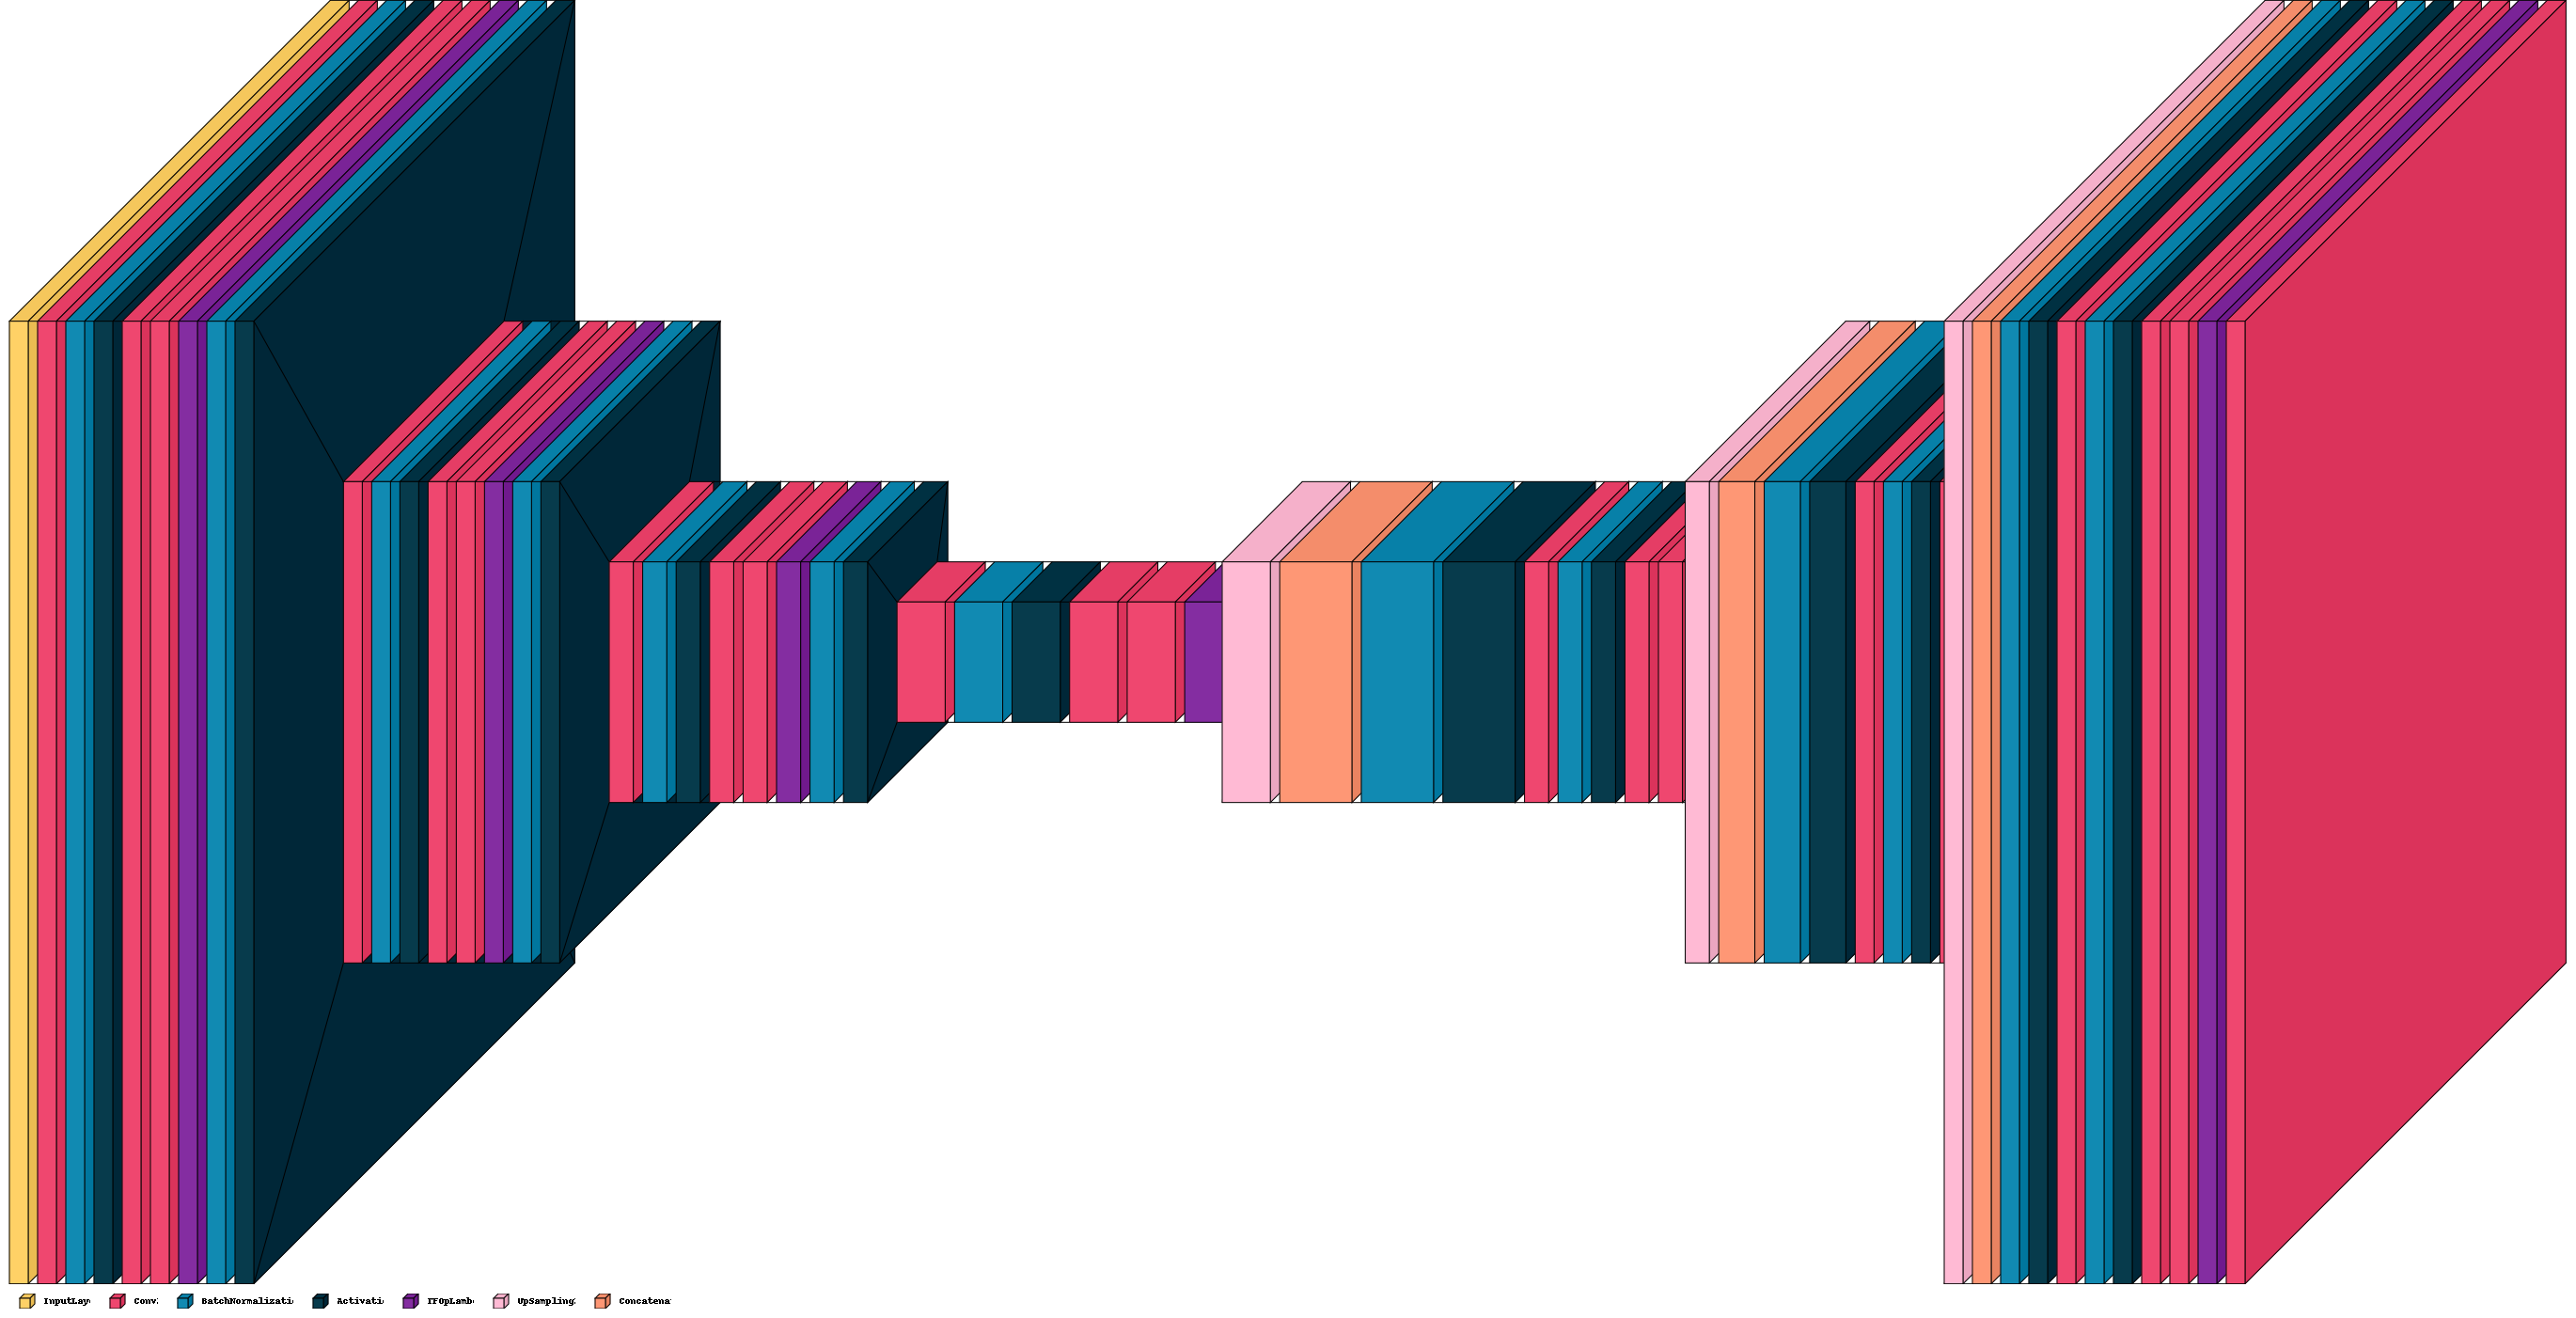

In [ ]:
visualkeras.layered_view(model, legend=True)

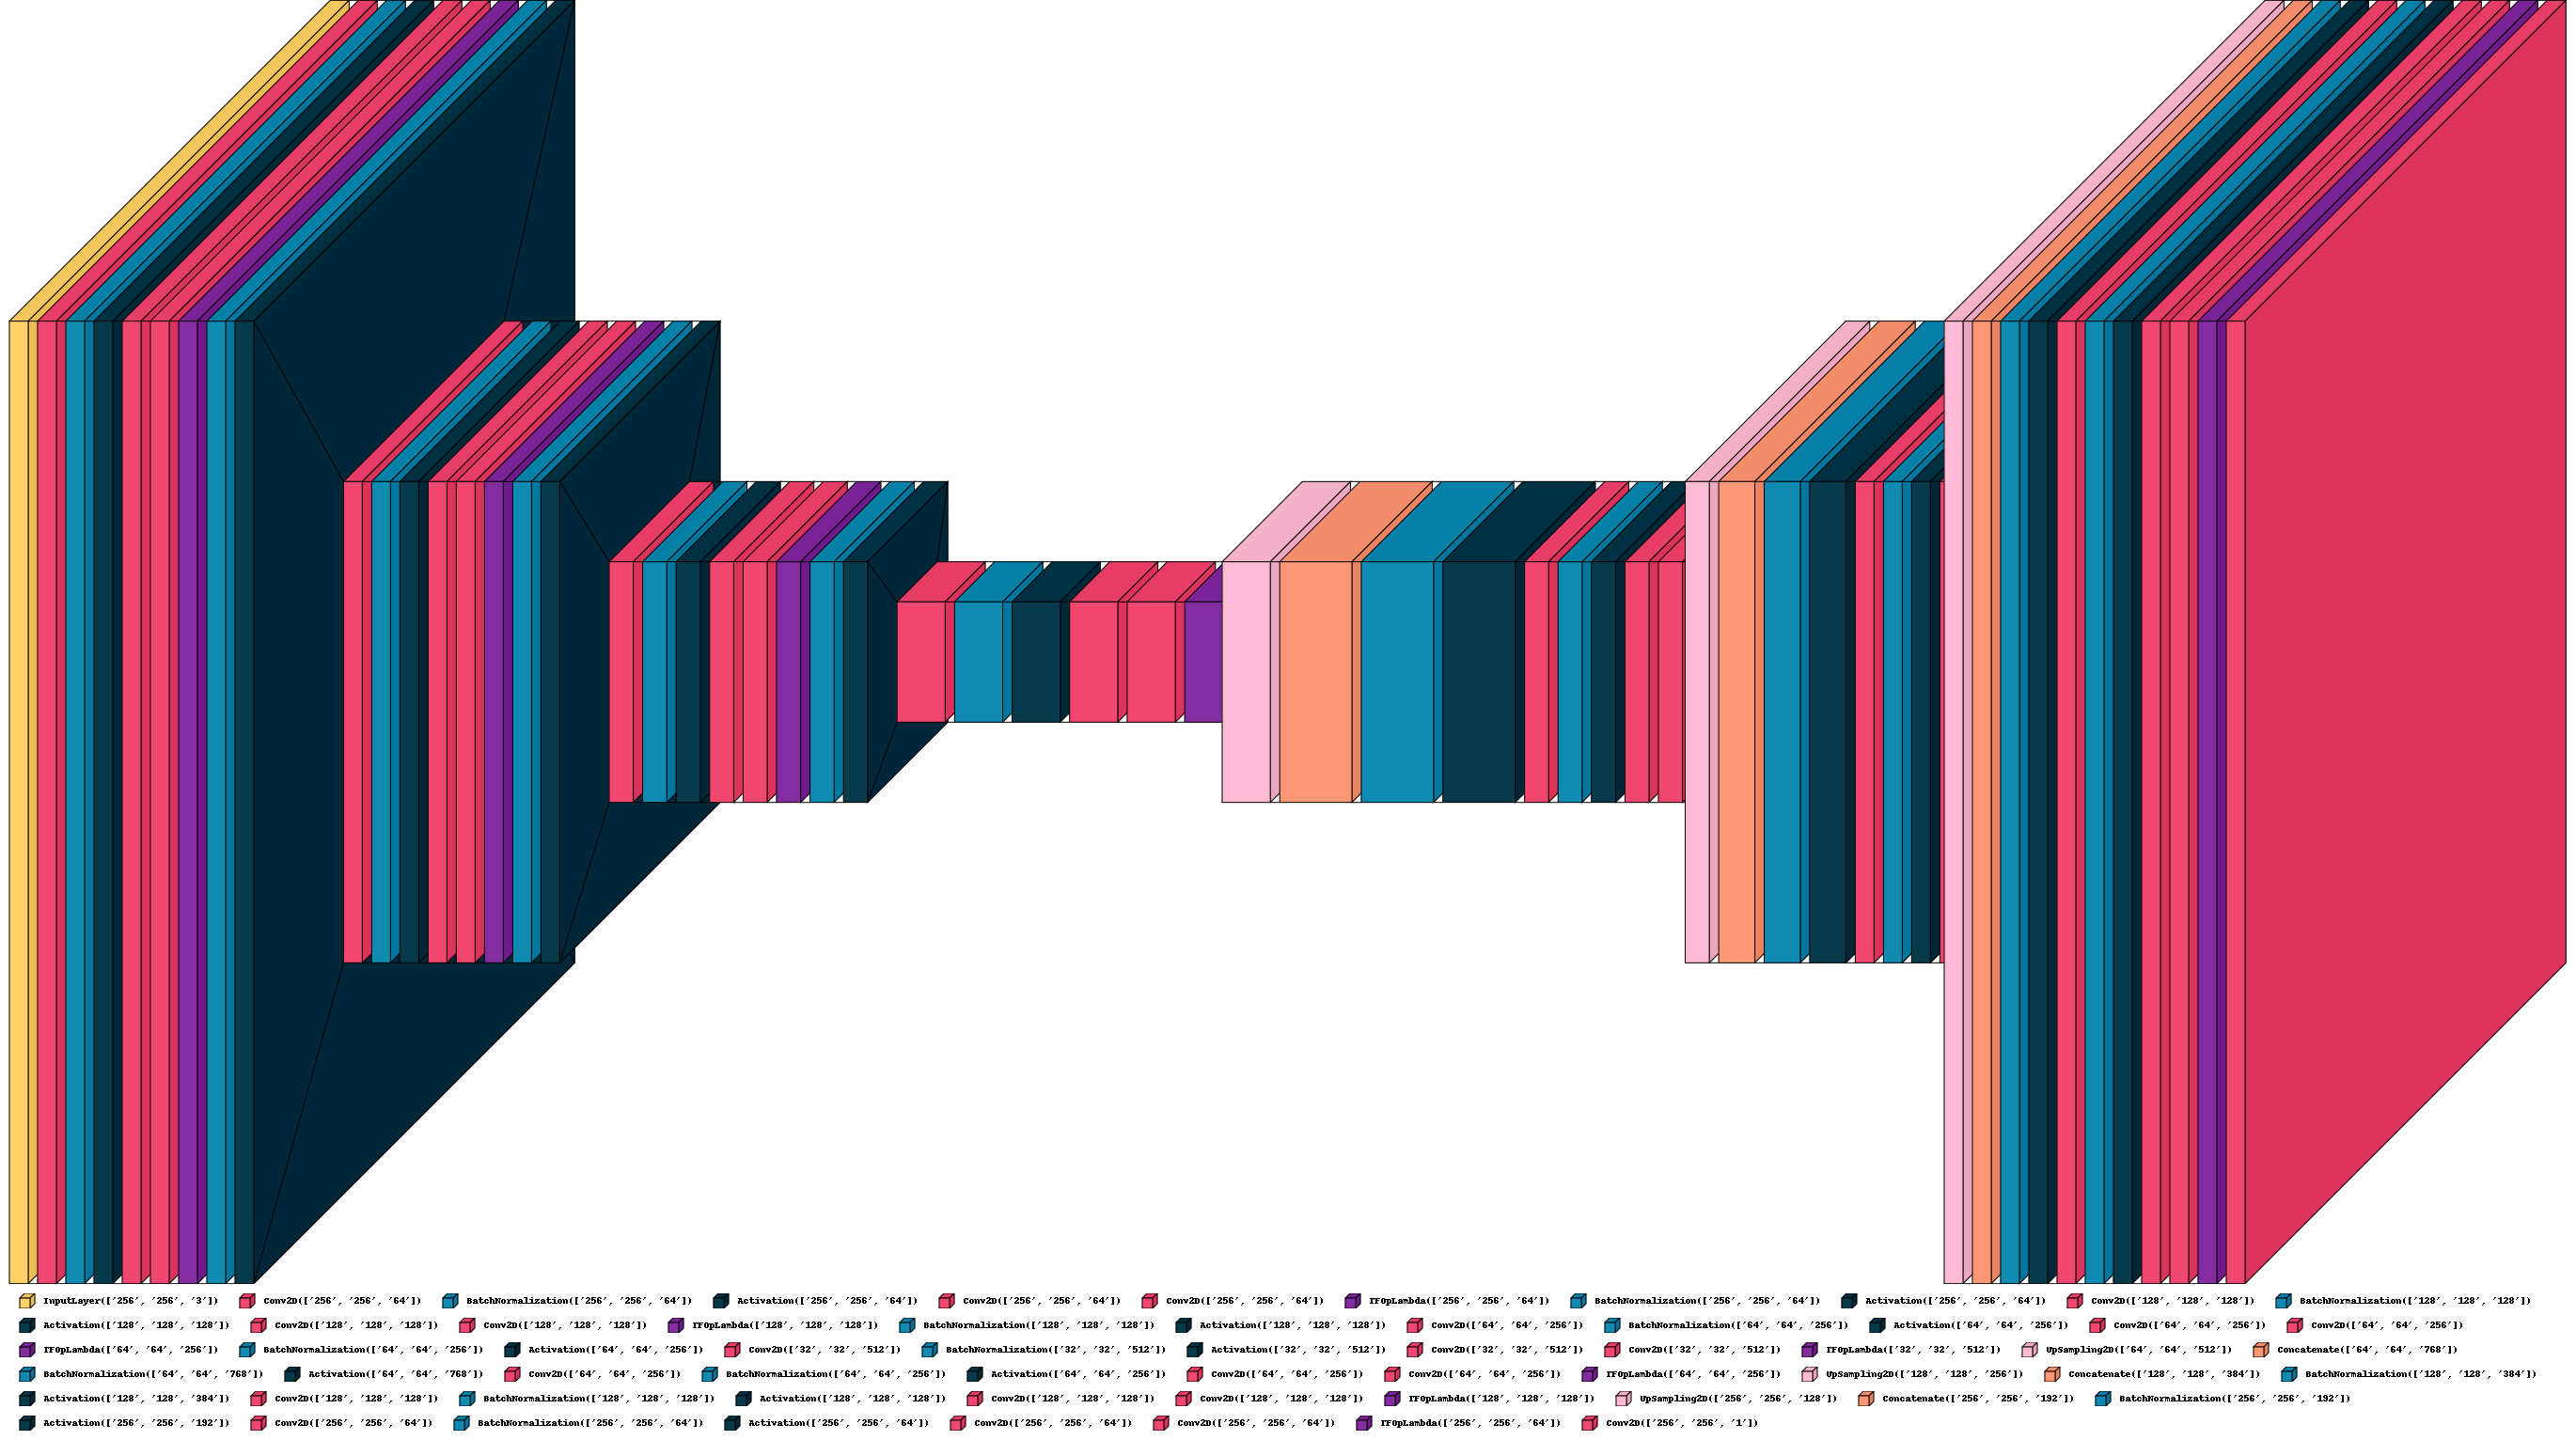

In [ ]:
visualkeras.layered_view(model, legend=True, show_dimension=True)

In [ ]:
""" Model """
model = build_resunet((H, W, 3))
model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coef])

callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    CSVLogger(csv_path),
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
    ]

model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    callbacks=callbacks
)

Train: 1377 - 1377
Valid: 459 - 459
Test : 459 - 459
Epoch 1/50
87/87 [==============================] - ETA: 0s - loss: 0.7875 - dice_coef: 0.2123 
Epoch 1: val_loss improved from inf to 1.00000, saving model to files/model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


87/87 [==============================] - 1693s 19s/step - loss: 0.7875 - dice_coef: 0.2123 - val_loss: 1.0000 - val_dice_coef: 1.8773e-12 - lr: 1.0000e-04
Epoch 2/50
86/87 [============================>.] - ETA: 0s - loss: 0.6786 - dice_coef: 0.3214
Epoch 2: val_loss did not improve from 1.00000
87/87 [==============================] - 60s 686ms/step - loss: 0.6782 - dice_coef: 0.3262 - val_loss: 1.0000 - val_dice_coef: 6.3529e-20 - lr: 1.0000e-04
Epoch 3/50
86/87 [============================>.] - ETA: 0s - loss: 0.5860 - dice_coef: 0.4140
Epoch 3: val_loss did not improve from 1.00000
87/87 [==============================] - 59s 682ms/step - loss: 0.5857 - dice_coef: 0.4190 - val_loss: 1.0000 - val_dice_coef: 6.3523e-20 - lr: 1.0000e-04
Epoch 4/50
86/87 [============================>.] - ETA: 0s - loss: 0.5129 - dice_coef: 0.4871
Epoch 4: val_loss improved from 1.00000 to 0.99834, saving model to files/model.h5
87/87 [==============================] - 60s 688ms/step - loss: 0.5126 - 

In [ ]:
""" Load the model """
with CustomObjectScope({"dice_coef": dice_coef, "dice_loss": dice_loss}):
    model = tf.keras.models.load_model(os.path.join("files", "model.h5"))

""" Prediction and Evaluation """
SCORE = []
for x, y in tqdm(zip(test_x, test_y), total=len(test_y)):
    """ Extracting the name """
    name = x.split("/")[-1]

    """ Reading the image """
    image = cv2.imread(x, cv2.IMREAD_COLOR) ## [H, w, 3]
    image = cv2.resize(image, (W, H))       ## [H, w, 3]
    x = image/255.0                         ## [H, w, 3]
    x = np.expand_dims(x, axis=0)           ## [1, H, w, 3]

    """ Reading the mask """
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (W, H))

    """ Prediction """
    y_pred = model.predict(x, verbose=0)[0]
    y_pred = np.squeeze(y_pred, axis=-1)
    y_pred = y_pred >= 0.5
    y_pred = y_pred.astype(np.int32)

    """ Saving the prediction """
    save_image_path = os.path.join("results", name)
    save_results(image, mask, y_pred, save_image_path)

    """ Flatten the array """
    mask = mask/255.0
    mask = (mask > 0.5).astype(np.int32).flatten()
    y_pred = y_pred.flatten()

    """ Calculating the metrics values """
    f1_value = f1_score(mask, y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(mask, y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
    precision_value = precision_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
    SCORE.append([name, f1_value, jac_value, recall_value, precision_value])

""" Metrics values """
score = [s[1:] for s in SCORE]
score = np.mean(score, axis=0)
print(f"F1: {score[0]:0.5f}")
print(f"Jaccard: {score[1]:0.5f}")
print(f"Recall: {score[2]:0.5f}")
print(f"Precision: {score[3]:0.5f}")

df = pd.DataFrame(SCORE, columns=["Image", "F1", "Jaccard", "Recall", "Precision"])
df.to_csv("files/score.csv")

# Zip the results folder
shutil.make_archive('results', 'zip', 'results')

# Download the zip file
files.download('results.zip')


100%|██████████| 459/459 [08:18<00:00,  1.09s/it]


F1: 0.55762
Jaccard: 0.46612
Recall: 0.54158
Precision: 0.69967


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# resUnet++.py

In [ ]:
def SE(inputs, ratio=8):
    ## [8, H, W, 32]
    channel_axis = -1
    num_filters = inputs.shape[channel_axis]
    se_shape = (1, 1, num_filters)

    x = L.GlobalAveragePooling2D()(inputs) ## [8, 32]
    x = L.Reshape(se_shape)(x)
    x = L.Dense(num_filters // ratio, activation='relu', use_bias=False)(x)
    x = L.Dense(num_filters, activation='sigmoid', use_bias=False)(x)

    x = L.Multiply()([inputs, x])
    return x


def stem_block(inputs, num_filters):
    ## Conv 1
    x = L.Conv2D(num_filters, 3, padding="same")(inputs)
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)
    x = L.Conv2D(num_filters, 3, padding="same")(x)

    ## Shortcut
    s = L.Conv2D(num_filters, 1, padding="same")(inputs)

    ## Add
    x = L.Add()([x, s])
    x = SE(x)
    return x

def resnet_block(inputs, num_filters, strides=1):
    ## SE
    inputs = SE(inputs)

    ## Conv 1
    x = L.BatchNormalization()(inputs)
    x = L.Activation("relu")(x)
    x = L.Conv2D(num_filters, 3, padding="same", strides=strides)(x)

    ## Conv 2
    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)
    x = L.Conv2D(num_filters, 3, padding="same", strides=1)(x)

    ## Shortcut
    s = L.Conv2D(num_filters, 1, padding="same", strides=strides)(inputs)

    ## Add
    x = L.Add()([x, s])

    return x

def aspp_block(inputs, num_filters):
    x1 = L.Conv2D(num_filters, 3, dilation_rate=6, padding="same")(inputs)
    x1 = L.BatchNormalization()(x1)

    x2 = L.Conv2D(num_filters, 3, dilation_rate=12, padding="same")(inputs)
    x2 = L.BatchNormalization()(x2)

    x3 = L.Conv2D(num_filters, 3, dilation_rate=18, padding="same")(inputs)
    x3 = L.BatchNormalization()(x3)

    x4 = L.Conv2D(num_filters, (3, 3), padding="same")(inputs)
    x4 = L.BatchNormalization()(x4)

    y = L.Add()([x1, x2, x3, x4])
    y = L.Conv2D(num_filters, 1, padding="same")(y)

    return y

def attetion_block(x1, x2):
    num_filters = x2.shape[-1]

    x1_conv = L.BatchNormalization()(x1)
    x1_conv = L.Activation("relu")(x1_conv)
    x1_conv = L.Conv2D(num_filters, 3, padding="same")(x1_conv)
    x1_pool = L.MaxPooling2D((2, 2))(x1_conv)

    x2_conv = L.BatchNormalization()(x2)
    x2_conv = L.Activation("relu")(x2_conv)
    x2_conv = L.Conv2D(num_filters, 3, padding="same")(x2_conv)

    x = L.Add()([x1_pool, x2_conv])

    x = L.BatchNormalization()(x)
    x = L.Activation("relu")(x)
    x = L.Conv2D(num_filters, 3, padding="same")(x)

    x = L.Multiply()([x, x2])
    return x

def resunet_pp(input_shape):
    """ Inputs """
    inputs = L.Input(input_shape)

    """ Encoder """
    c1 = stem_block(inputs, 16)
    c2 = resnet_block(c1, 32, strides=2)
    c3 = resnet_block(c2, 64, strides=2)
    c4 = resnet_block(c3, 128, strides=2)

    """ Bridge """
    b1 = aspp_block(c4, 256)

    """ Decoder """
    d1 = attetion_block(c3, b1)
    d1 = L.UpSampling2D((2, 2))(d1)
    d1 = L.Concatenate()([d1, c3])
    d1 = resnet_block(d1, 128)

    d2 = attetion_block(c2, d1)
    d2 = L.UpSampling2D((2, 2))(d2)
    d2 = L.Concatenate()([d2, c2])
    d2 = resnet_block(d2, 64)

    d3 = attetion_block(c1, d2)
    d3 = L.UpSampling2D((2, 2))(d3)
    d3 = L.Concatenate()([d3, c1])
    d3 = resnet_block(d3, 32)

    """ Output"""
    outputs = aspp_block(d3, 16)
    outputs = L.Conv2D(1, 1, padding="same")(outputs)
    outputs = L.Activation("sigmoid")(outputs)

    """ Model """
    model = Model(inputs, outputs)
    return model

input_shape = (256, 256, 3)
model = resunet_pp(input_shape)
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_123 (Conv2D)         (None, 256, 256, 16)         448       ['input_4[0][0]']             
                                                                                                  
 batch_normalization_90 (Ba  (None, 256, 256, 16)         64        ['conv2d_123[0][0]']          
 tchNormalization)                                                                                
                                                                                                  
 activation_69 (Activation)  (None, 256, 256, 16)         0         ['batch_normalization_90

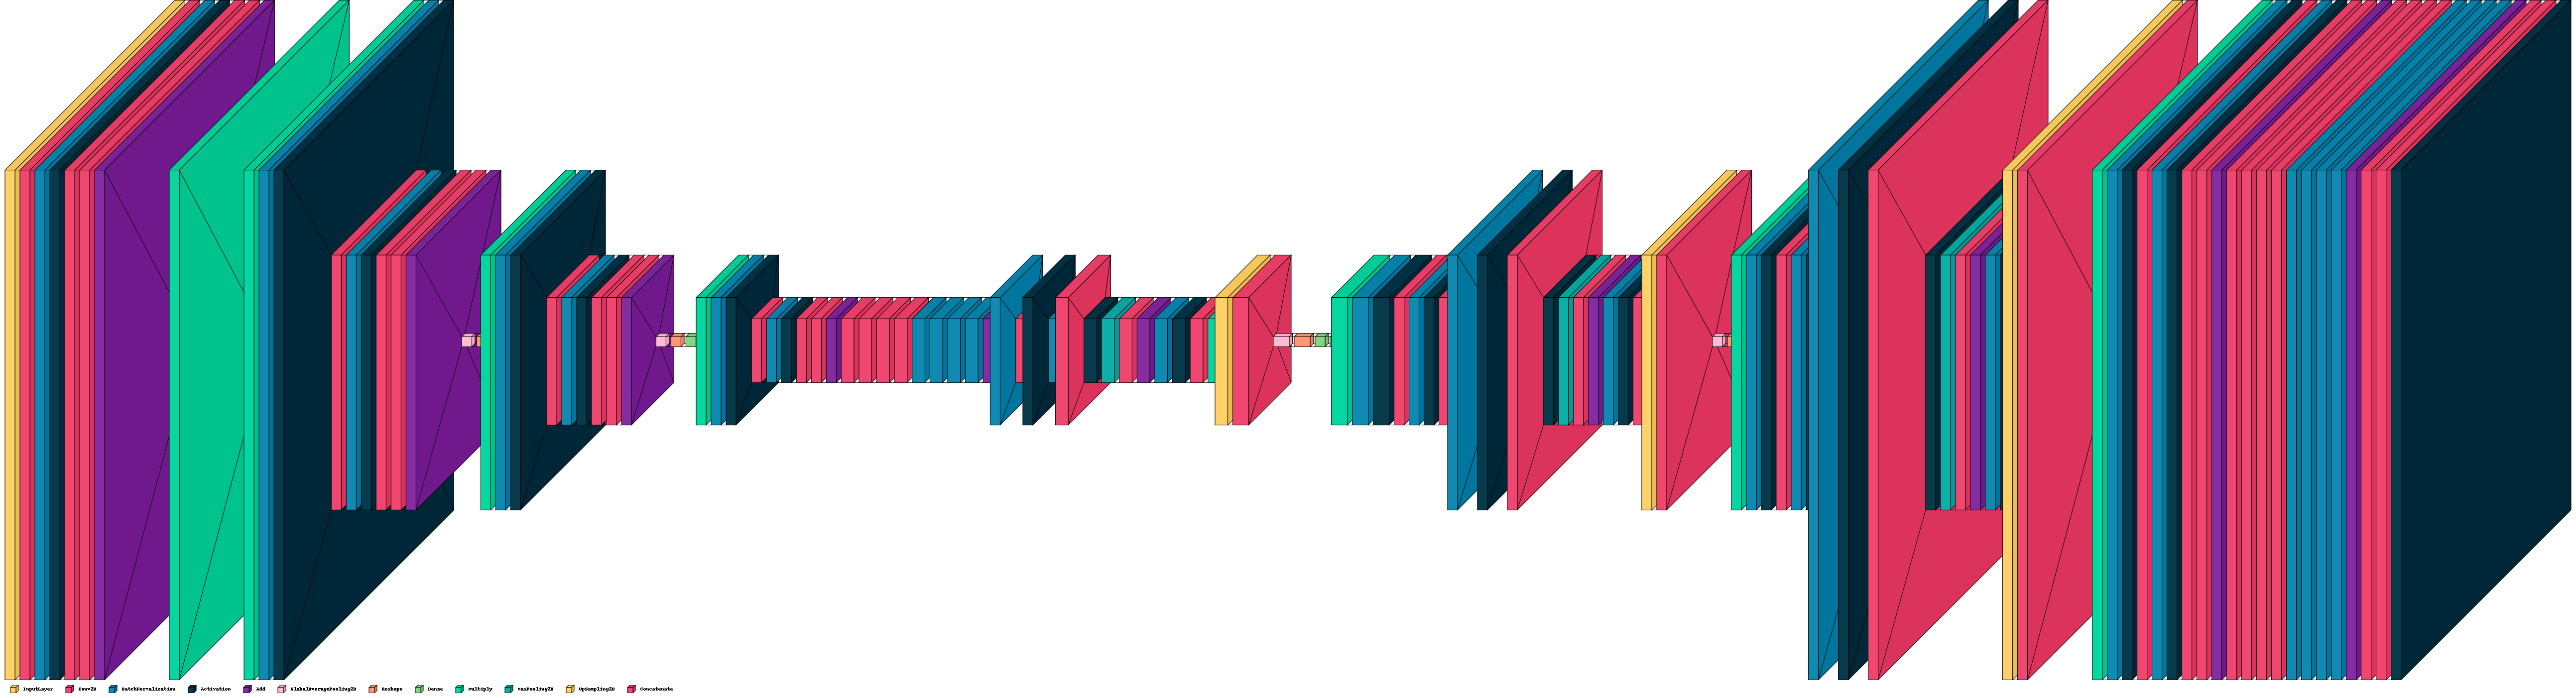

In [ ]:
visualkeras.layered_view(model, legend=True)

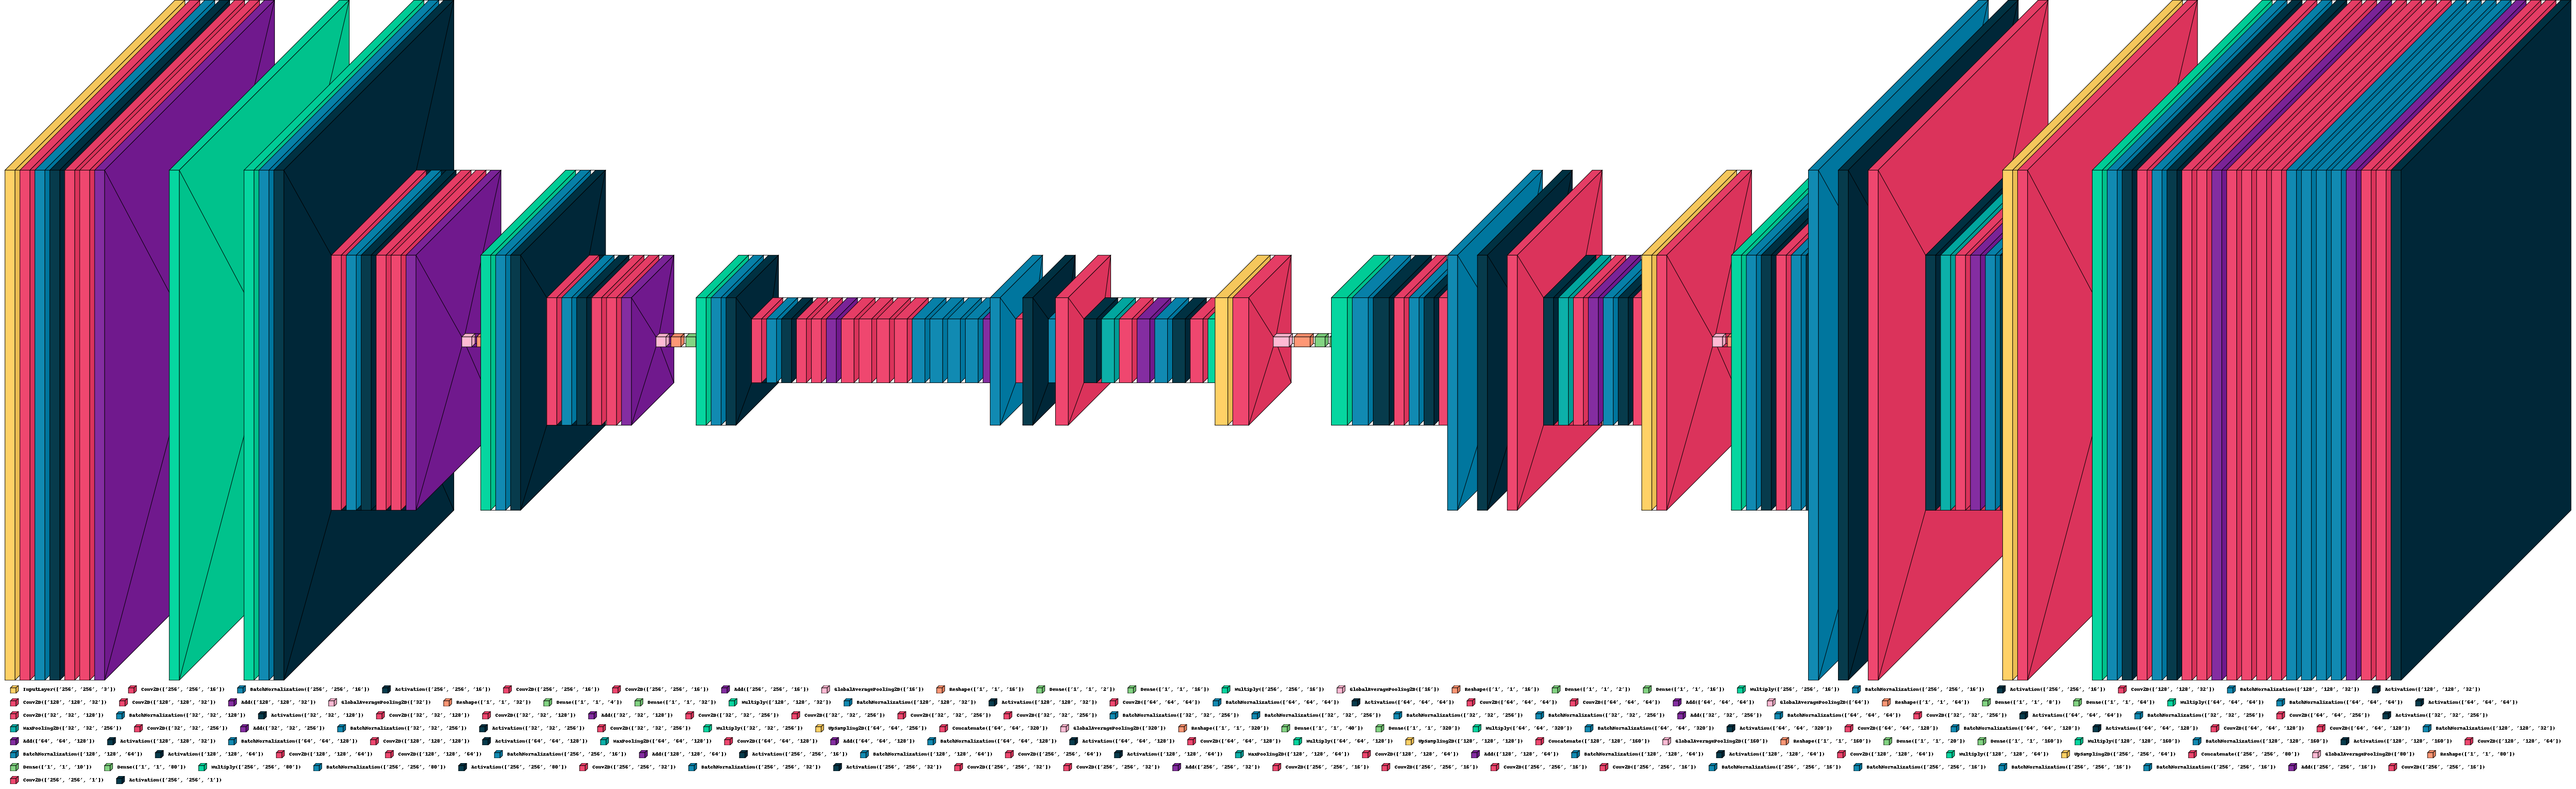

In [ ]:
visualkeras.layered_view(model, legend=True, show_dimension=True)

In [ ]:
# """ Hyperparameters """
batch_size = 16

""" Model """
model = resunet_pp((H, W, 3))
model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coef])

callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    CSVLogger(csv_path),
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
    ]

model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    callbacks=callbacks
)

Epoch 1/50
44/44 [==============================] - ETA: 0s - loss: 0.8824 - dice_coef: 0.1187 
Epoch 1: val_loss improved from inf to 0.97109, saving model to files/model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


44/44 [==============================] - 1341s 28s/step - loss: 0.8824 - dice_coef: 0.1187 - val_loss: 0.9711 - val_dice_coef: 0.0286 - lr: 1.0000e-04
Epoch 2/50
43/44 [============================>.] - ETA: 0s - loss: 0.7630 - dice_coef: 0.2370
Epoch 2: val_loss did not improve from 0.97109
44/44 [==============================] - 48s 1s/step - loss: 0.7630 - dice_coef: 0.2370 - val_loss: 0.9771 - val_dice_coef: 0.0227 - lr: 1.0000e-04
Epoch 3/50
43/44 [============================>.] - ETA: 0s - loss: 0.6760 - dice_coef: 0.3240
Epoch 3: val_loss did not improve from 0.97109
44/44 [==============================] - 48s 1s/step - loss: 0.6759 - dice_coef: 0.3248 - val_loss: 0.9840 - val_dice_coef: 0.0159 - lr: 1.0000e-04
Epoch 4/50
43/44 [============================>.] - ETA: 0s - loss: 0.5907 - dice_coef: 0.4093
Epoch 4: val_loss did not improve from 0.97109
44/44 [==============================] - 48s 1s/step - loss: 0.5907 - dice_coef: 0.4097 - val_loss: 0.9893 - val_dice_coef: 0.0

In [ ]:
""" Load the model """
with CustomObjectScope({"dice_coef": dice_coef, "dice_loss": dice_loss}):
    model = tf.keras.models.load_model(os.path.join("files", "model.h5"))

""" Prediction and Evaluation """
SCORE = []
for x, y in tqdm(zip(test_x, test_y), total=len(test_y)):
    """ Extracting the name """
    name = x.split("/")[-1]

    """ Reading the image """
    image = cv2.imread(x, cv2.IMREAD_COLOR) ## [H, w, 3]
    image = cv2.resize(image, (W, H))       ## [H, w, 3]
    x = image/255.0                         ## [H, w, 3]
    x = np.expand_dims(x, axis=0)           ## [1, H, w, 3]

    """ Reading the mask """
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (W, H))

    """ Prediction """
    y_pred = model.predict(x, verbose=0)[0]
    y_pred = np.squeeze(y_pred, axis=-1)
    y_pred = y_pred >= 0.5
    y_pred = y_pred.astype(np.int32)

    """ Saving the prediction """
    save_image_path = os.path.join("results", name)
    save_results(image, mask, y_pred, save_image_path)

    """ Flatten the array """
    mask = mask/255.0
    mask = (mask > 0.5).astype(np.int32).flatten()
    y_pred = y_pred.flatten()

    """ Calculating the metrics values """
    f1_value = f1_score(mask, y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(mask, y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
    precision_value = precision_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
    SCORE.append([name, f1_value, jac_value, recall_value, precision_value])

""" Metrics values """
score = [s[1:] for s in SCORE]
score = np.mean(score, axis=0)
print(f"F1: {score[0]:0.5f}")
print(f"Jaccard: {score[1]:0.5f}")
print(f"Recall: {score[2]:0.5f}")
print(f"Precision: {score[3]:0.5f}")

df = pd.DataFrame(SCORE, columns=["Image", "F1", "Jaccard", "Recall", "Precision"])
df.to_csv("files/score.csv")

# Zip the results folder
shutil.make_archive('results', 'zip', 'results')

# Download the zip file
files.download('results.zip')


100%|██████████| 459/459 [06:50<00:00,  1.12it/s]


F1: 0.62490
Jaccard: 0.51823
Recall: 0.67110
Precision: 0.63667


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# multiresunet.py

In [ ]:
def conv_block(x, num_filters, kernel_size, padding="same", act=True):
    x = Conv2D(num_filters, kernel_size, padding=padding, use_bias=False)(x)
    x = BatchNormalization()(x)
    if act:
        x = Activation("relu")(x)
    return x

def multires_block(x, num_filters, alpha=1.67):
    W = num_filters * alpha

    x0 = x
    x1 = conv_block(x0, int(W*0.167), 3)
    x2 = conv_block(x1, int(W*0.333), 3)
    x3 = conv_block(x2, int(W*0.5), 3)
    xc = Concatenate()([x1, x2, x3])
    xc = BatchNormalization()(xc)

    nf = int(W*0.167) + int(W*0.333) + int(W*0.5)
    sc = conv_block(x0, nf, 1, act=False)

    x = Activation("relu")(xc + sc)
    x = BatchNormalization()(x)
    return x

def res_path(x, num_filters, length):
    for i in range(length):
        x0 = x
        x1 = conv_block(x0, num_filters, 3, act=False)
        sc = conv_block(x0, num_filters, 1, act=False)
        x = Activation("relu")(x1 + sc)
        x = BatchNormalization()(x)
    return x

def encoder_block(x, num_filters, length):
    x = multires_block(x, num_filters)
    s = res_path(x, num_filters, length)
    p = MaxPooling2D((2, 2))(x)
    return s, p

def decoder_block(x, skip, num_filters):
    x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(x)
    x = Concatenate()([x, skip])
    x = multires_block(x, num_filters)
    return x

def build_multiresunet(shape):
    """ Input """
    inputs = Input(shape)

    """ Encoder """
    p0 = inputs
    s1, p1 = encoder_block(p0, 32, 4)
    s2, p2 = encoder_block(p1, 64, 3)
    s3, p3 = encoder_block(p2, 128, 2)
    s4, p4 = encoder_block(p3, 256, 1)

    """ Bridge """
    b1 = multires_block(p4, 512)

    """ Decoder """
    d1 = decoder_block(b1, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    """ Model """
    model = Model(inputs, outputs, name="MultiResUNET")

    return model

shape = (256, 256, 3)
model = build_multiresunet(shape)
model.summary()

Model: "MultiResUNET"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_113 (Conv2D)         (None, 256, 256, 8)          216       ['input_5[0][0]']             
                                                                                                  
 batch_normalization_69 (Ba  (None, 256, 256, 8)          32        ['conv2d_113[0][0]']          
 tchNormalization)                                                                                
                                                                                                  
 activation_80 (Activation)  (None, 256, 256, 8)          0         ['batch_normalizati

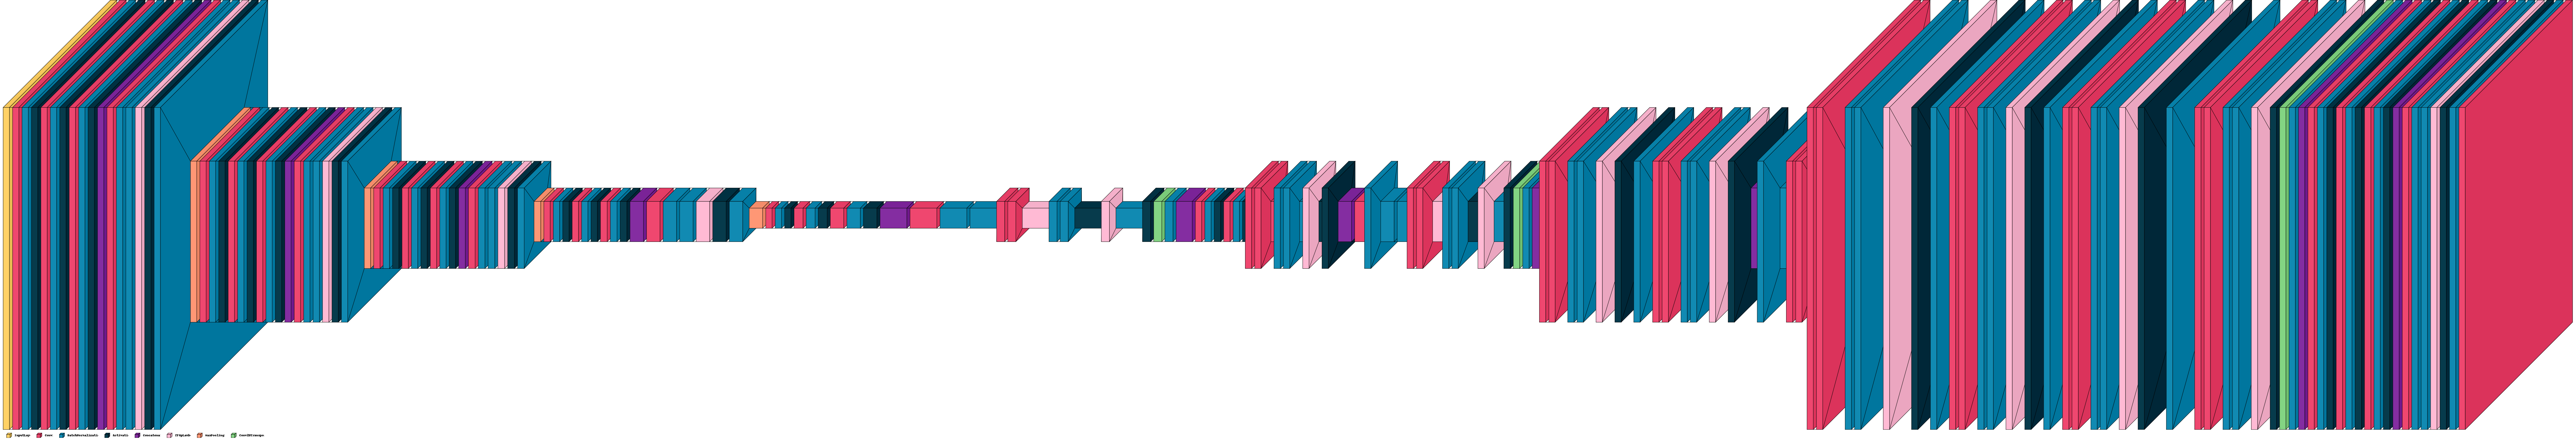

In [ ]:
visualkeras.layered_view(model, legend=True)

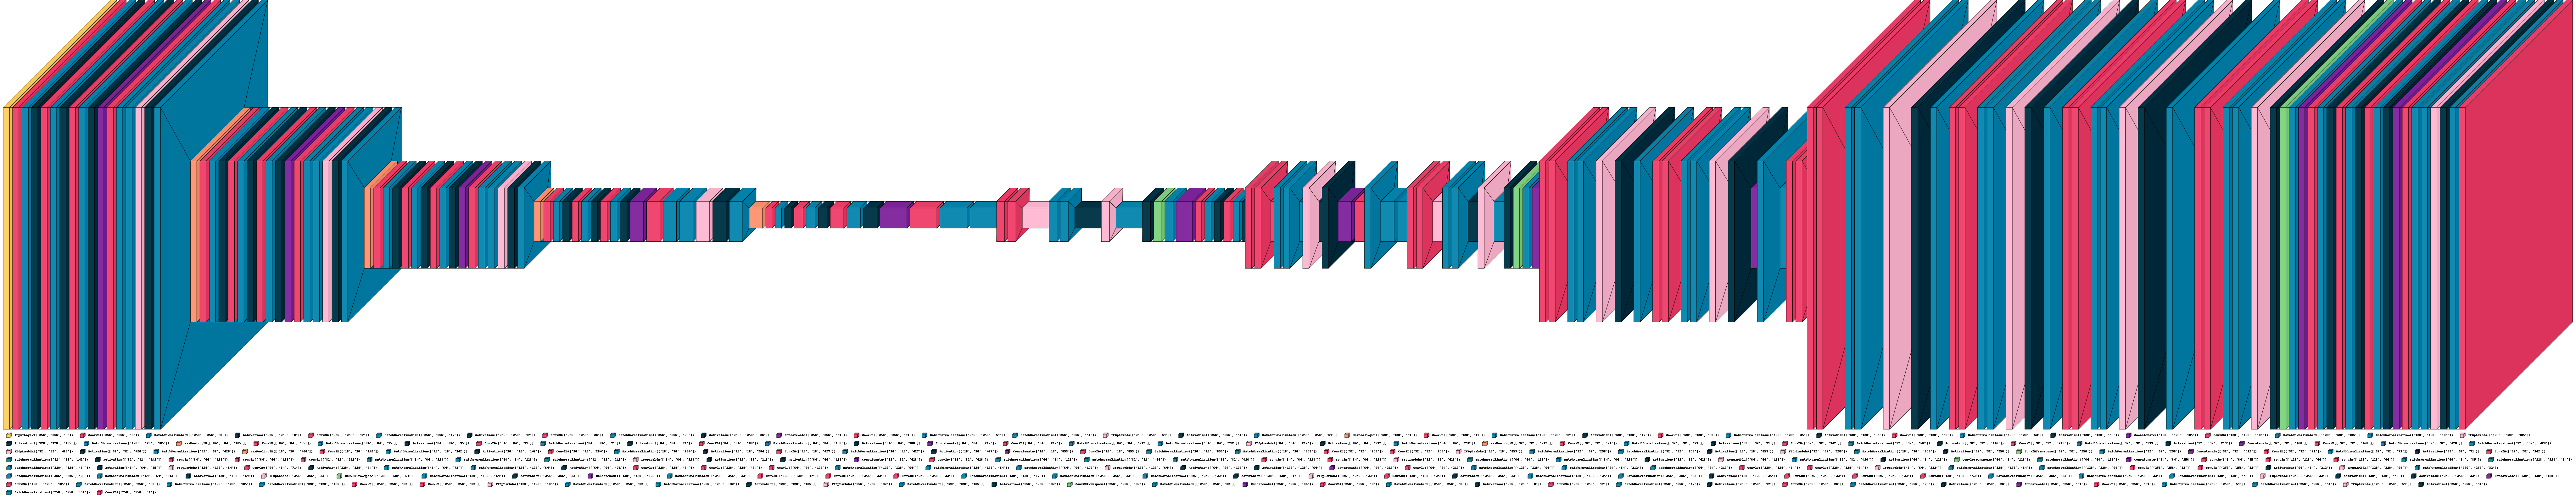

In [ ]:
visualkeras.layered_view(model, legend=True, show_dimension=True)

In [ ]:
# """ Hyperparameters """
batch_size = 16


""" Model """
model = build_multiresunet((H, W, 3))
model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coef])

callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    CSVLogger(csv_path),
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
    ]

model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    callbacks=callbacks
)


Epoch 1/50
44/44 [==============================] - ETA: 0s - loss: 0.9421 - dice_coef: 0.0579
Epoch 1: val_loss improved from inf to 0.96844, saving model to files/model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


44/44 [==============================] - 168s 2s/step - loss: 0.9421 - dice_coef: 0.0579 - val_loss: 0.9684 - val_dice_coef: 0.0311 - lr: 1.0000e-04
Epoch 2/50
43/44 [============================>.] - ETA: 1s - loss: 0.9123 - dice_coef: 0.0877
Epoch 2: val_loss improved from 0.96844 to 0.96323, saving model to files/model.h5
44/44 [==============================] - 54s 1s/step - loss: 0.9123 - dice_coef: 0.0875 - val_loss: 0.9632 - val_dice_coef: 0.0363 - lr: 1.0000e-04
Epoch 3/50
43/44 [============================>.] - ETA: 1s - loss: 0.8782 - dice_coef: 0.1218
Epoch 3: val_loss did not improve from 0.96323
44/44 [==============================] - 53s 1s/step - loss: 0.8783 - dice_coef: 0.1202 - val_loss: 0.9683 - val_dice_coef: 0.0313 - lr: 1.0000e-04
Epoch 4/50
43/44 [============================>.] - ETA: 1s - loss: 0.8645 - dice_coef: 0.1355
Epoch 4: val_loss did not improve from 0.96323
44/44 [==============================] - 53s 1s/step - loss: 0.8645 - dice_coef: 0.1350 - val

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
""" Load the model """
with CustomObjectScope({"dice_coef": dice_coef, "dice_loss": dice_loss}):
    model = tf.keras.models.load_model(os.path.join("files", "model.h5"))

""" Prediction and Evaluation """
SCORE = []
for x, y in tqdm(zip(test_x, test_y), total=len(test_y)):
    """ Extracting the name """
    name = x.split("/")[-1]

    """ Reading the image """
    image = cv2.imread(x, cv2.IMREAD_COLOR) ## [H, w, 3]
    image = cv2.resize(image, (W, H))       ## [H, w, 3]
    x = image/255.0                         ## [H, w, 3]
    x = np.expand_dims(x, axis=0)           ## [1, H, w, 3]

    """ Reading the mask """
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (W, H))

    """ Prediction """
    y_pred = model.predict(x, verbose=0)[0]
    y_pred = np.squeeze(y_pred, axis=-1)
    y_pred = y_pred >= 0.5
    y_pred = y_pred.astype(np.int32)

    """ Saving the prediction """
    save_image_path = os.path.join("results", name)
    save_results(image, mask, y_pred, save_image_path)

    """ Flatten the array """
    mask = mask/255.0
    mask = (mask > 0.5).astype(np.int32).flatten()
    y_pred = y_pred.flatten()

    """ Calculating the metrics values """
    f1_value = f1_score(mask, y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(mask, y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
    precision_value = precision_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
    SCORE.append([name, f1_value, jac_value, recall_value, precision_value])

""" Metrics values """
score = [s[1:] for s in SCORE]
score = np.mean(score, axis=0)
print(f"F1: {score[0]:0.5f}")
print(f"Jaccard: {score[1]:0.5f}")
print(f"Recall: {score[2]:0.5f}")
print(f"Precision: {score[3]:0.5f}")

df = pd.DataFrame(SCORE, columns=["Image", "F1", "Jaccard", "Recall", "Precision"])
df.to_csv("files/score.csv")

# Zip the results folder
shutil.make_archive('results', 'zip', 'results')

# Download the zip file
files.download('results.zip')

# Download the score.csv file
files.download('files/score.csv')
# Download the score.csv file
files.download('files/log.csv')


100%|██████████| 459/459 [01:26<00:00,  5.33it/s]


F1: 0.64426
Jaccard: 0.54625
Recall: 0.62609
Precision: 0.73557


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Compare

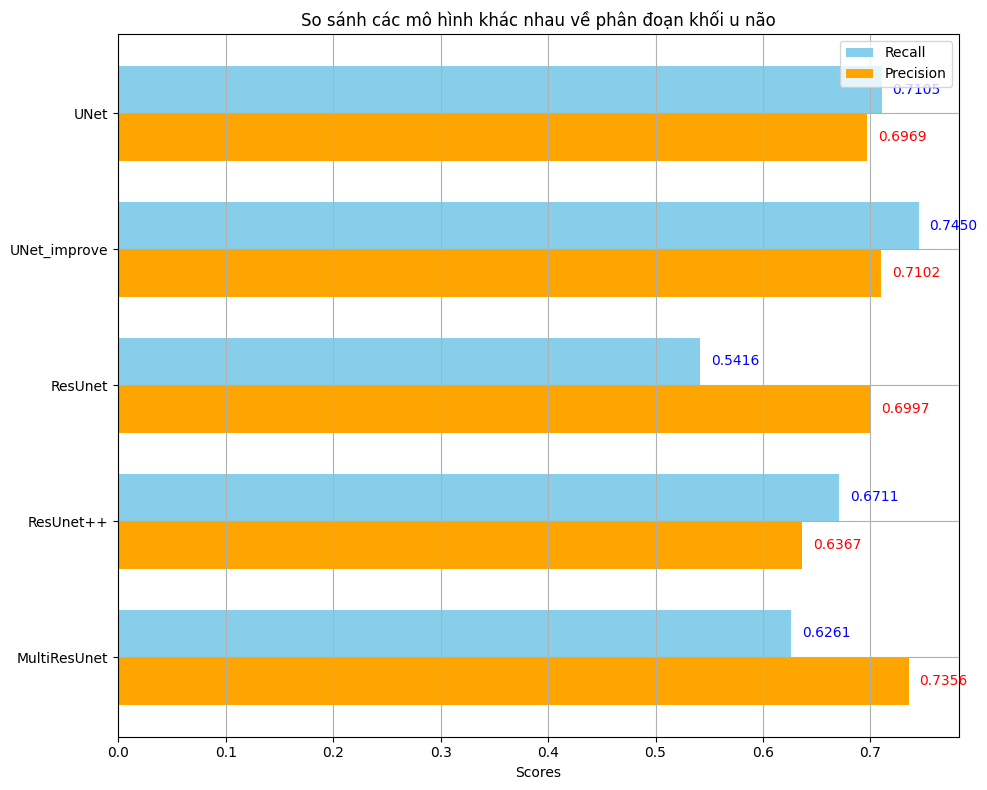

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

models = ['UNet', 'UNet_improve', 'ResUnet', 'ResUnet++', 'MultiResUnet']
recall_scores = [0.71053, 0.74504, 0.54158, 0.67110, 0.62609]
precision_scores = [0.69687, 0.71021, 0.69967, 0.63667, 0.73557]

fig, ax = plt.subplots(figsize=(10, 8))
bar_width = 0.35
index = np.arange(len(models))

bar1 = ax.barh(index, recall_scores, bar_width, label='Recall', color='skyblue')
bar2 = ax.barh(index + bar_width, precision_scores, bar_width, label='Precision', color='orange')

ax.set_xlabel('Scores')
ax.set_title('So sánh các mô hình khác nhau về phân đoạn khối u não')
ax.set_yticks(index + bar_width / 2)
ax.set_yticklabels(models)
ax.legend()

# Add value labels on bars
for i, v in enumerate(recall_scores):
    ax.text(v + 0.01, i, f'{v:.4f}', color='blue', va='center')
for i, v in enumerate(precision_scores):
    ax.text(v + 0.01, i + bar_width, f'{v:.4f}', color='red', va='center')

plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()


# Deploy Model

In [ ]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.7 MB/s eta 0:00:00


In [ ]:
# Step 1: Install the necessary packages
!pip install pyngrok

In [ ]:
import os
from threading import Thread
from pyngrok import ngrok

In [ ]:
# Add your ngrok token here
ngrok.set_auth_token('2jio8cIdAxbPfQ1TqhyM2mnuD9z_6LZr2woo8gTK9HMkeCqCE')

In [ ]:
def run_streamlit():
    # Change the port if 8501 is already in use or if you prefer another port
    os.system('streamlit run /content/drive/MyDrive/Colab\ Notebooks/BrainMRI/app.py --server.port 8501')


In [ ]:
# Start a thread to run the Streamlit app
thread = Thread(target=run_streamlit)
thread.start()

In [ ]:
# Open a tunnel to the streamlit port 8501
public_url = ngrok.connect(addr='8501', proto='http', bind_tls=True)
print('Your Streamlit app is live at:', public_url)

Your Streamlit app is live at: NgrokTunnel: "https://cb71-34-75-60-21.ngrok-free.app" -> "http://localhost:8501"
